# Modeling the Joint Distribution of Wind Speed and Direction  using Gaussain Mixture Models

OEN Method: Harris, Cook
The parent wind speed distribution: Why Weibull?
http://www.sciencedirect.com/science/article/pii/S0167610514001056

Gaussian Mixture Models, 
http://scikit-learn.org/stable/modules/mixture.html

# 1. Set up

## 1.1 Environment

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from import_file import *
from helpers.parallel_helper import *
load_libs()

plt.rcParams['axes.autolimit_mode'] = 'round_numbers'
plt.rcParams['axes.xmargin'] = 0.
plt.rcParams['axes.ymargin'] = 0.

## 1.2 Read Data

In [2]:
# file_path= "./data/NCDC/us/baltimore/dat.txt" # time too short
# file_path= './data/NCDC/uk/boscombe_down/dat.txt' # 4?
# file_path= './data/NCDC/uk/middle_wallop/dat.txt' # good
# file_path= './data/NCDC/uk/southhamption/dat.txt' # high 0
# file_path= './data/NCDC/uk/bournemouth/dat.txt' 4?
# file_path= './data/NCDC/uk/tiree/dat.txt'  # try 4
# file_path= "./data/NCDC/uk/bealach_na_ba/dat.txt" # 
# file_path= "./data/NCDC/uk/skye_lusa/dat.txt" # 
# file_path= "./data/NCDC/uk/south_uist_range/dat.txt" 
# file_path= './data/NCDC/uk/marham/dat.txt' 
# file_path= "./data/NCDC/uk/holbeach/dat.txt"
# file_path= "./data/NCDC/uk/weybourne/dat.txt"
# file_path= "./data/NCDC/uk/cambridge/dat.txt"
# file_path= "./data/NCDC/uk/wattisham/dat.txt"
# file_path= "./data/NCDC/uk/benbecula/dat.txt" # truncate (untruncate in m/s), 4?

# file_path= "./data/NCDC/southeast_asia/singapore_changi/dat.txt" # 4 or 5?
# file_path= "./data/NCDC/southeast_asia/sultan_ismail/dat.txt" # 
# file_path= "./data/NCDC/southeast_asia/paya_lebar/dat.txt" # 2010-2014 has problem
# file_path= "./data/NCDC/east_asia/cheongju_intl/dat.txt" # 2005-2009  may have problem, fit is good
# file_path= "./data/NCDC/east_asia/daegu_ab/dat.txt" # recent 5 year may have problem, but fit is generally good

# file_path= "./data/NCDC/europe/landsberg_lech/dat.txt" # very good, can try 4
# file_path= "./data/NCDC/europe/laupheim/dat.txt" # double peak, 4; very good
# file_path= "./data/NCDC/europe/vatry/dat.txt"  # double peak, initial speed (should be good with m/s)
# file_path= "./data/NCDC/europe/avord/dat.txt" # try 4, initial speed (should be good with m/s)
# file_path= './data/NCDC/europe/ciampino/dat.txt' # try 4, bandwidth?
# file_path= "./data/NCDC/europe/holzdorf/dat.txt"
# file_path= "./data/NCDC/europe/neuburg/dat.txt"
# file_path= "./data/NCDC/europe/valladolid/dat.txt"
# file_path= "./data/NCDC/europe/barayas/dat.txt" # 
# file_path= "./data/NCDC/europe/huspel_aws/dat.txt"  # integer, 4?
# file_path= "./data/NCDC/europe/diepholz/dat.txt" # recent year is integer with less data, use m/s
# file_path= './data/NCDC/europe/tenerife_sur/dat.txt'  # some directions are blocked

# file_path= "./data/NCDC/oceania/narrandera/dat.txt" # high 0
# file_path= "./data/NCDC/oceania/brisbane_archerfield/dat.txt" # high 0
# file_path= "./data/NCDC/oceania/auckland_intl/dat.txt"  # Weird KDE shape, 4?
# file_path= "./data/NCDC/oceania/canberra/dat.txt" # high 0

# file_path= "./data/NCDC/cn/shanghai/hongqiao_intl/dat.txt" 
# file_path= "./data/NCDC/cn/shanghai/pudong/dat.txt"
# file_path= "./data/NCDC/cn/tianjing/binhai/dat.txt" # recent 5 year has small problem, good overall, few 0
# file_path= "./data/NCDC/cn/tianjing/tianjing/dat.txt" # 16 sectors
# file_path= "./data/NCDC/cn/hefei_luogang/dat.txt" # recent 5 year has small problem, good overall, few 0
# file_path= "./data/NCDC/cn/南京lukou/dat.txt" 
# file_path= "./data/NCDC/cn/shijiazhuang_zhengding/dat.txt" 
# file_path= "./data/NCDC/cn/henan_gushi/dat.txt" # 16 sectors, fit not very good
# file_path= "./data/NCDC/cn/郑州xinzheng/dat.txt" # fit is not good
# file_path= "./data/NCDC/cn/nanning_wuxu/dat.txt" # recent 5 year has problem
# file_path= './data/NCDC/cn/macau/dat.txt'  
# file_path= "./data/NCDC/cn/hk_intl/dat.txt" # few initial data

# file_path= "./data/cn_database/广州.txt" 
# file_path= "./data/cn_database/北京.txt" 

# file_path = 'TOP/hr_avg.csv' # High 0
file_path = './data/asos/denver/hr_avg.csv' # few 0 

# file_path = './data/asos/bismarck_ND/hr_avg.csv' 
# file_path = './data/asos/aberdeen_SD/hr_avg.csv' # only to 2012
# file_path = './data/asos/minneapolis/hr_avg.csv'

# file_path = './data/asos/lincoln_NE/hr_avg.csv' 
# file_path = './data/asos/des_moines_IA/hr_avg.csv'
# file_path = './data/asos/springfield_IL/hr_avg.csv'

In [3]:
if "cn_database" in file_path: 
    df = read_cn_database(file_path)
elif 'NCDC' in file_path:
    df = pd.read_csv(file_path, header=0, skipinitialspace=True, dtype={'HrMn':'object'})
    df.rename(columns={'Date':'date','Dir':'dir','Spd':'speed','Type':'type','I.1':'wind_type'}, inplace=True)
    df = df[['date','HrMn','type','dir','speed','wind_type' ]]
    integer_data = True
else:
    df = pd.read_csv(file_path, header=0, skipinitialspace=True, dtype={'HrMn':'object'})
    df['type']='default'
    df['wind_type']='default'
    df = df.dropna()
    integer_data = False
    knot_unit = True

In [4]:
df['time']=pd.to_datetime(df["date"].astype(str).map(str) + df["HrMn"], format='%Y%m%d%H%M')
df['HrMn']=df['HrMn'].astype(int)
df = df.query("(dir <= 999) & (speed < 100) & \
              (date >= 19700000) & (date < 20170000) ")

D:\ProgramData\Anaconda3\lib\site-packages\matplotlib\__init__.py:938: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


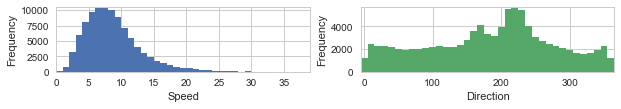

In [5]:
plot_speed_and_angle_distribution(df.speed, df.dir)

In [6]:
# Dir [10,360]=> [0,350]
df['dir'] = df['dir'].apply(lambda x: x%360 if x < 999 else x) 
df['month'] = df['date']%10000//100
df['speed_origin'] = df['speed']
# Convert Windrose coordianates to Polar Cooridinates 
df['dir_windrose'] = df['dir']
df['dir'] = df['dir'].apply(lambda x: (90 - x)%360 if x < 999 else x)
df.describe()

date            Hr         speed           dir     speed_max  \
count  9.794300e+04  97943.000000  97943.000000  97943.000000  97943.000000   
mean   2.010666e+07     11.497412      8.686951    195.168067     14.387286   
std    3.408681e+04      6.910621      4.314636     96.304651      6.788288   
min    2.005010e+07      0.000000      0.000000      0.014511      0.000000   
25%    2.008031e+07      6.000000      5.650000    113.107559     10.000000   
50%    2.011020e+07     11.000000      7.983333    216.605148     13.000000   
75%    2.014013e+07     17.000000     10.766667    269.573639     17.000000   
max    2.016123e+07     23.000000     38.566667    359.991440    164.000000   

               HrMn         month  speed_origin  dir_windrose  
count  97943.000000  97943.000000  97943.000000  97943.000000  
mean    1149.741176      6.547441      8.686951    183.271536  
std      691.062106      3.488276      4.314636     93.187466  
min        0.000000      1.000000      0.000000      0.003395  
25%      600.000000      3.000000      5.650000    113.073608  
50%     1100.000000      7.000000      7.983333    196.061478  
75%     1700.000000     10.000000     10.766667    245.531441  
max     2300.000000     12.000000     38.566667    359.993317

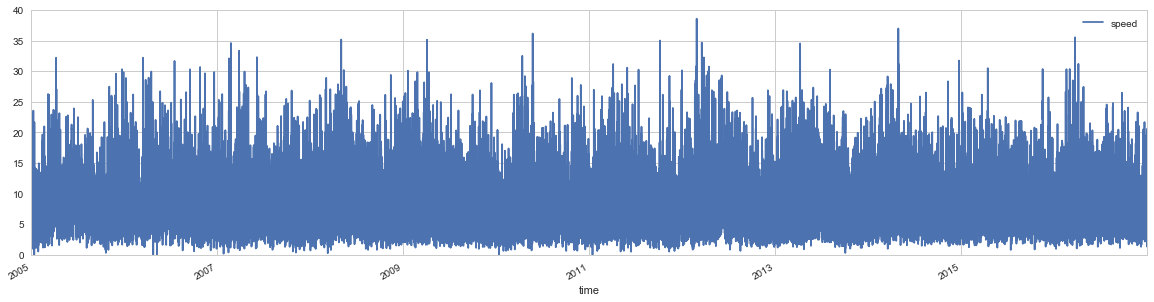

In [7]:
df.plot(x='time', y='speed',legend=True,figsize=(20,5))

### 1.2.1 Unit Detection

In [8]:
if 'knot_unit' not in globals():
    df['decimal'] = df.speed % 1
    df.decimal.hist(alpha=0.5, label='m/s', figsize=(4, 3))
    knot_unit = True if len(df.query('decimal >= 0.2')) / len(df) > 0.3 else False

    if knot_unit:
        df['speed'] = df['speed'] * 1.943845
        df['decimal'] = df.speed % 1
        df.decimal.hist(alpha=0.5, label='knot')
        # need more elaboration, some is not near an integer
        df['speed'] = df['speed'].apply(lambda x: int(round(x)))
    plt_configure(xlabel='Decimal', ylabel='Frequency', legend={'loc': 'best'}, title='Decimal Distribution')
    df.drop(['decimal'], 1,inplace=True)
print(knot_unit)

True


### 1.2.2 Sampling Type Selection

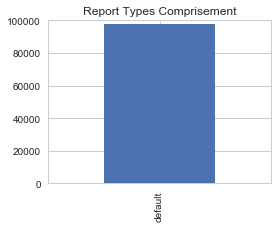

In [9]:
sample_type = df.query('date > 20000000')['type']
sample_type.value_counts().plot(
    kind = 'bar', title = 'Report Types Comprisement', figsize=(4,3))

report_type_most_used = sample_type.value_counts().argmax()
df = df.query("type==@report_type_most_used")

### 1.2.3 Sampling Time Selection

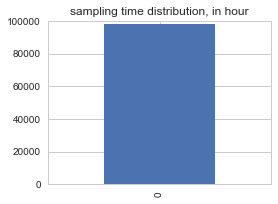

In [10]:
df['sample_time'] = df.HrMn % 100 
sample_time = df.query('date > 20000000')['sample_time']
sample_time.value_counts().plot(
    kind = 'bar', title = 'sampling time distribution, in hour', figsize=(4,3))

# Need more elaboration
sample_times = sample_time.value_counts()[sample_time.value_counts() > 2000]
sample_times = sample_times.index.tolist()
df = df.query("sample_time in @sample_times")
df.drop(['sample_time'], 1,inplace=True)

In [11]:
df['HrMn'].value_counts().sort_index()

0       4062
100     4059
200     4067
300     4064
400     4072
500     4090
600     4091
700     4090
800     4097
900     4090
1000    4099
1100    4099
1200    4108
1300    4107
1400    4098
1500    4094
1600    4085
1700    4085
1800    4070
1900    4067
2000    4072
2100    4063
2200    4065
2300    4049
Name: HrMn, dtype: int64

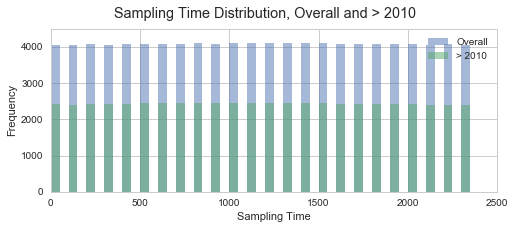

In [12]:
MID_YEAR = (min(df.date)//10000+max(df.date)//10000)//2
bins=arange(0, 2400+100, 50)

df['HrMn'].plot(kind='hist', alpha=0.5,bins=bins, label='Overall')

df.query('date > @MID_YEAR * 10000')['HrMn'].plot(
    kind='hist', alpha=0.5,bins=bins, label='> %s' %  MID_YEAR )

plt_configure(xlabel='Sampling Time', ylabel='Frequency', legend={'loc':'best'}, figsize=(8, 3), 
              title = 'Sampling Time Distribution, Overall and > %s ' %  MID_YEAR)

## 1.3 Data Wrangling

### 1.3.1 Artefacts

#### 1.3.1.1 wrong direction record

In [13]:
if integer_data:
    display(df.query("(dir % 10 >= 0.1) & (dir != 999)"))
    df = df.query('(dir % 10 <= 0.1) | (dir == 999)')

#### 1.3.1.2 sudden increase in speed

date  Hr      speed         dir  speed_max  HrMn     type  \
57593  20120227  12  38.566667  286.600204       51.0  1200  default   
57592  20120227  11  37.633333  285.266617       51.0  1100  default   
75590  20140429   9  36.966667  110.281494       54.0   900  default   
43068  20100524  12  36.150000  234.570236       55.0  1200  default   
91707  20160323   9  35.527273  111.345642       48.0   900  default   
75591  20140429  10  35.516667  110.642059       57.0  1000  default   
57594  20120227  13  35.483333  290.466736       47.0  1300  default   
43067  20100524  11  35.483333  239.645554       56.0  1100  default   
91709  20160323  11  35.283333  115.800079       46.0  1100  default   
25705  20080502  13  35.166667   90.766418       51.0  1300  default   

      wind_type                time  month  speed_origin  dir_windrose  \
57593   default 2012-02-27 12:00:00      2     38.566667    163.399796   
57592   default 2012-02-27 11:00:00      2     37.633333    164.733383   
75590   default 2014-04-29 09:00:00      4     36.966667    339.718506   
43068   default 2010-05-24 12:00:00      5     36.150000    215.429764   
91707   default 2016-03-23 09:00:00      3     35.527273    338.654358   
75591   default 2014-04-29 10:00:00      4     35.516667    339.357941   
57594   default 2012-02-27 13:00:00      2     35.483333    159.533264   
43067   default 2010-05-24 11:00:00      5     35.483333    210.354446   
91709   default 2016-03-23 11:00:00      3     35.283333    334.199921   
25705   default 2008-05-02 13:00:00      5     35.166667    359.233582   

          incre  incre_reverse  
57593  0.933333       3.083333  
57592  3.050000      -0.933333  
75590  2.883333       1.450000  
43068  0.666667       2.933333  
91707  2.327273       1.986732  
75591 -1.450000       1.166667  
57594 -3.083333       1.866667  
43067  1.733333      -0.666667  
91709  1.742793       1.166667  
25705  6.800000       1.983333

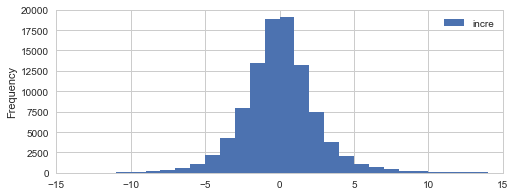

In [14]:
# sudden increse
df['incre'] = df.speed.diff(1)
df['incre'].fillna(0, inplace=True)
df['incre_reverse'] = df.speed.diff(-1)
df['incre_reverse'].fillna(0, inplace=True)

display(df.sort_values(by='speed',ascending=False).head(10))
df['incre'].plot(kind='hist', bins=arange(-15, 15), legend=True, figsize=(8, 3))

In [15]:
incre_threshold = 20 if knot_unit else 10
print('sudden increase number', len(df.query('(incre > @incre_threshold )&(incre_reverse > @incre_threshold )')))
df = df.query('(incre < @incre_threshold )|(incre_reverse < @incre_threshold )')

# Check the max speed
display(df.sort_values(by='speed',ascending=False).head(10))
df.drop(['incre', 'incre_reverse'], 1, inplace=True)

sudden increase number 1


date  Hr      speed         dir  speed_max  HrMn     type  \
57593  20120227  12  38.566667  286.600204       51.0  1200  default   
57592  20120227  11  37.633333  285.266617       51.0  1100  default   
75590  20140429   9  36.966667  110.281494       54.0   900  default   
43068  20100524  12  36.150000  234.570236       55.0  1200  default   
91707  20160323   9  35.527273  111.345642       48.0   900  default   
75591  20140429  10  35.516667  110.642059       57.0  1000  default   
57594  20120227  13  35.483333  290.466736       47.0  1300  default   
43067  20100524  11  35.483333  239.645554       56.0  1100  default   
91709  20160323  11  35.283333  115.800079       46.0  1100  default   
25705  20080502  13  35.166667   90.766418       51.0  1300  default   

      wind_type                time  month  speed_origin  dir_windrose  \
57593   default 2012-02-27 12:00:00      2     38.566667    163.399796   
57592   default 2012-02-27 11:00:00      2     37.633333    164.733383   
75590   default 2014-04-29 09:00:00      4     36.966667    339.718506   
43068   default 2010-05-24 12:00:00      5     36.150000    215.429764   
91707   default 2016-03-23 09:00:00      3     35.527273    338.654358   
75591   default 2014-04-29 10:00:00      4     35.516667    339.357941   
57594   default 2012-02-27 13:00:00      2     35.483333    159.533264   
43067   default 2010-05-24 11:00:00      5     35.483333    210.354446   
91709   default 2016-03-23 11:00:00      3     35.283333    334.199921   
25705   default 2008-05-02 13:00:00      5     35.166667    359.233582   

          incre  incre_reverse  
57593  0.933333       3.083333  
57592  3.050000      -0.933333  
75590  2.883333       1.450000  
43068  0.666667       2.933333  
91707  2.327273       1.986732  
75591 -1.450000       1.166667  
57594 -3.083333       1.866667  
43067  1.733333      -0.666667  
91709  1.742793       1.166667  
25705  6.800000       1.983333

### 1.3.2 0 Speed

In [16]:
with_too_many_zero, null_wind_frequency = is_with_too_many_zero(df.query("(date >= 20050000)"))
delete_zero = with_too_many_zero
if delete_zero:
    df = df.query('(speed > 0)')
print(delete_zero, null_wind_frequency)

False 0.00106185293337


### 1.3.3 Direction re-aligment and 999
For some dataset, the 16 sectors are not record properly,

e.g. the sectors are [0,20,30,50], need to redistribute the angle into 22.5

In [17]:
display(df['dir'].value_counts().sort_index())
effective_column = df.query('dir < 999')['dir'].value_counts()[df['dir'].value_counts() > 30].sort_index()
try:
    SECTOR_LENGTH = 360/len(effective_column) 
except: 
    SECTOR_LENGTH = 10
print(len(effective_column), SECTOR_LENGTH)

0.014511      1
0.016525      1
0.018158      1
0.029037      1
0.033180      1
0.035858      1
0.037437      1
0.041985      1
0.051239      1
0.051437      1
0.052582      1
0.057495      1
0.062546      1
0.066536      1
0.075546      1
0.079353      1
0.079498      1
0.081787      1
0.088310      1
0.091675      1
0.105461      1
0.107071      1
0.111580      1
0.119888      1
0.121048      1
0.131935      1
0.142563      1
0.146370      1
0.149208      1
0.150406      1
             ..
359.859802    1
359.860542    1
359.869453    1
359.869728    1
359.883270    1
359.886284    1
359.886475    1
359.888481    1
359.890282    1
359.902054    1
359.904007    1
359.916008    1
359.919540    1
359.921570    1
359.924393    1
359.928329    1
359.934036    1
359.942276    1
359.949677    1
359.950600    1
359.954826    1
359.955902    1
359.960083    1
359.974716    1
359.978699    1
359.981461    1
359.988014    1
359.989517    1
359.990578    1
359.991440    1
Name: dir, dtype: int64

0 10


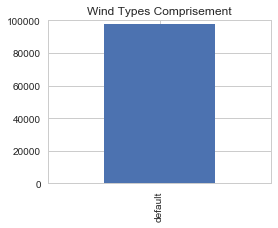

In [18]:
df=realign_direction(df, effective_column)
df=fill_direction_999(df, SECTOR_LENGTH)

### 1.3.4 Time Shift Comparison

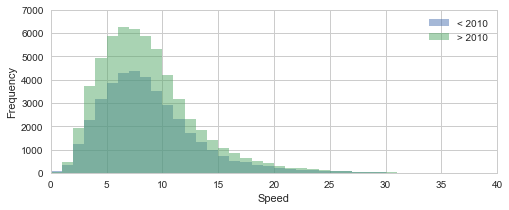

In [19]:
DIR_REDISTRIBUTE = 'even'
if DIR_REDISTRIBUTE == 'even':
    DIR_BIN = arange(-5, 360, 10) 
elif DIR_REDISTRIBUTE == 'round_up':
    DIR_BIN = arange(0, 360+10, 10) 

# Comparison between mid_year, looking for: 
# 1. Odd Even Bias
# 2. Time Shift of Wind Speed Distribution
bins = arange(0, max(df.speed) + 1)
df.query('date < @MID_YEAR * 10000')['speed'].plot(
    kind='hist', alpha=0.5,bins=bins, label='< %s' % MID_YEAR)

df.query('date > @MID_YEAR * 10000')['speed'].plot(
    kind='hist', alpha=0.5,bins=bins, label='> %s' % MID_YEAR)

plt.suptitle('Speed Comparison between year < %s, > %s ' % (MID_YEAR, MID_YEAR), fontsize = 14)
plt_configure(xlabel='Speed', ylabel='Frequency', legend=True, figsize=(8, 3))

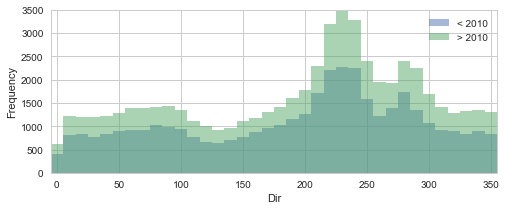

In [20]:
df.query('date < @MID_YEAR * 10000')['dir'].plot(
    kind='hist', alpha=0.5,bins=DIR_BIN, label='< %s' % MID_YEAR)

df.query('date > @MID_YEAR * 10000')['dir'].plot(
    kind='hist', alpha=0.5,bins=DIR_BIN, label='> %s' % MID_YEAR)

plt.suptitle('Dir Comparison between year < %s, and > %s ' % (MID_YEAR, MID_YEAR), fontsize = 14)
plt_configure(xlabel='Dir', ylabel='Frequency', legend={'loc':'best'}, figsize=(8, 3),tight='x')

2005 - 2009


D:\ProgramData\Anaconda3\lib\site-packages\matplotlib\__init__.py:938: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


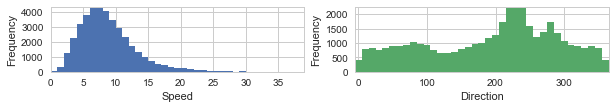

2010 - 2014


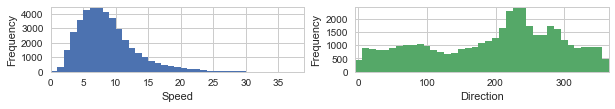

2015 - 2016


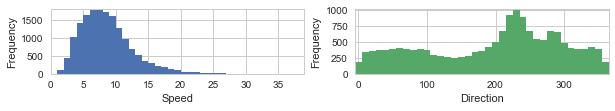

In [21]:
# Inspect the time shift of speed and degree distribution, and odd-even bias
check_time_shift(df)

## 1.4 Re-distribute Direction and Speed
e.g. Dir 50 -> -45 ~ 55, to make KDE result better

In [22]:
if integer_data:
    df = randomize_angle(df, DIR_REDISTRIBUTE, SECTOR_LENGTH)

In [23]:
if integer_data:
    if delete_zero:
        redistribute_method = 'down'
    else:
        redistribute_method = 'up'

    df, speed_redistribution_info = randomize_speed(df, redistribute_method)

## 1.5 Generate (x,y) from (speed,dir)

In [24]:
# Cook orientation
# df['dir']= (df['dir'] + 180)%360

In [25]:
# There might be a small dot in the centre, which is due to too many zero (more than 1 speed) in center
# Scatter plot in matplot has performance issue, the speed is very slow
df['x'] = df['speed'] * cos(df['dir'] * pi / 180.0)
df['y'] = df['speed'] * sin(df['dir'] * pi / 180.0)

# 2. Re-select Data and Configs

## 2.1 Data Overview

In [26]:
## Summery of the data selection
print('Knot unit?', knot_unit)
print('Report type used:', report_type_most_used)
print('Sampling time used:', sample_times)
if 'speed_redistribution_info' in globals():
    print('Speed redistribution info:', speed_redistribution_info )

df_all_years = df # for later across-year comparison
df = df_all_years.query('(date >= 20100000) & (date < 20150000)')
# df = df.query('(HrMn == 0) and (speed >= 0.5) and (date%10000 > 900) and (date%10000 < 1000)' )
df.describe()

Knot unit? True
Report type used: default
Sampling time used: [0]


date            Hr         speed           dir     speed_max  \
count  4.172800e+04  41728.000000  41728.000000  41728.000000  41728.000000   
mean   2.012078e+07     11.489072      8.670099    195.407002     14.532760   
std    1.424338e+04      6.905997      4.423991     96.176311      6.944848   
min    2.010010e+07      0.000000      0.000000      0.018158      0.000000   
25%    2.011033e+07      6.000000      5.550000    113.787033     10.000000   
50%    2.012071e+07     11.000000      7.916667    217.178055     13.000000   
75%    2.013101e+07     17.000000     10.733333    269.615685     18.000000   
max    2.014123e+07     23.000000     38.566667    359.991440    147.000000   

               HrMn         month  speed_origin  dir_windrose             x  \
count  41728.000000  41728.000000  41728.000000  41728.000000  41728.000000   
mean    1148.907209      6.515122      8.670099    183.400513     -0.908509   
std      690.599661      3.474396      4.423991     93.158424      6.200044   
min        0.000000      1.000000      0.000000      0.003395    -32.430400   
25%      600.000000      3.000000      5.550000    113.691959     -5.189935   
50%     1100.000000      7.000000      7.916667    196.084129     -1.187596   
75%     1700.000000     10.000000     10.733333    245.847393      3.479516   
max     2300.000000     12.000000     38.566667    359.983246     29.023923   

                  y  
count  41728.000000  
mean      -1.608477  
std        7.272614  
min      -36.959268  
25%       -6.587139  
50%       -2.338541  
75%        3.039242  
max       34.674768

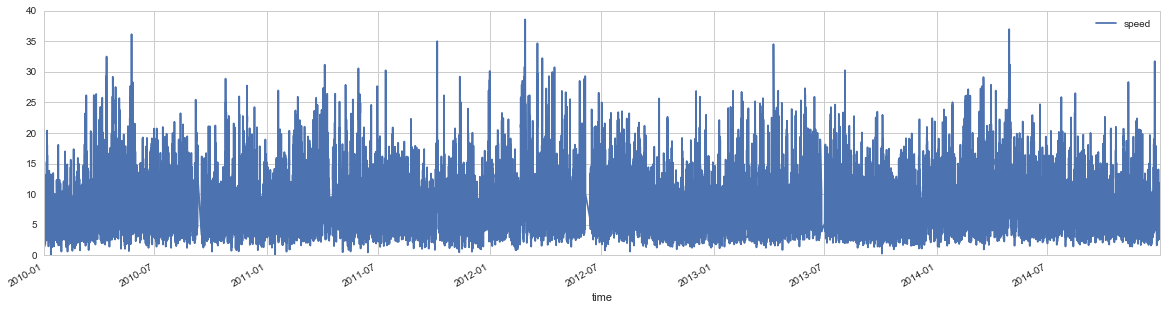

In [27]:
df.plot(x='time', y='speed',legend=True,figsize=(20,5))

D:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


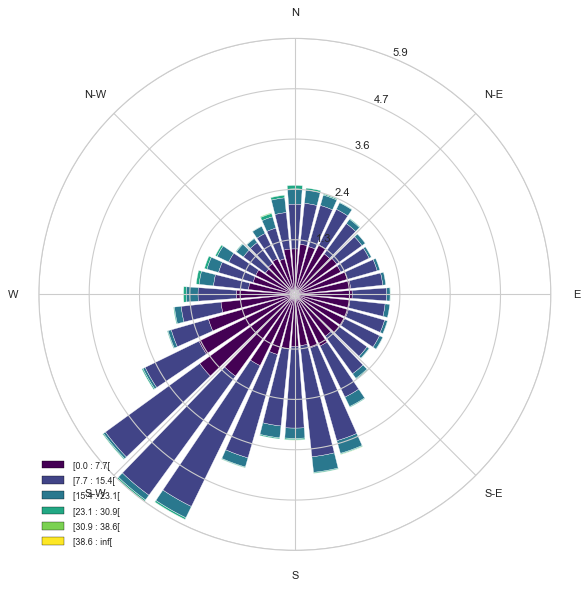

In [28]:
# 90 degree is east
ax = WindroseAxes.from_ax()
viridis = plt.get_cmap('viridis')
ax.bar(df.dir_windrose, df.speed, normed=True, opening=0.8, edgecolor='white', nsector=36, cmap=viridis)
ax.set_legend()

In [29]:
ax, _params = WindAxes.from_ax().pdf(df.speed, bins=arange(0, max(df.speed)))
plt_configure(figsize=(4,3),xlabel='V',ylabel='PDF')

fig,ax = plt.subplots()
ecdf = sm.distributions.ECDF(df.speed)
x = linspace(0, df.speed.max())
y = ecdf(x)
plot(log(x), log(-log(1-y)),'o', label='ECDF')

k_shape, _, lamb_scale = sp.stats.weibull_min.fit(df.speed, loc=0)
y=1-exp(-(x/lamb_scale)**k_shape) # cdf
plot(log(x), log(-log(1-y)),'-', label='Weibull')
plt_configure(xlabel="ln(V)", ylabel="ln(-ln(1-P)",legend={'loc':'best'},figsize=(4,3))
align_figures()
print(k_shape, lamb_scale)

D:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:8: RuntimeWarning: divide by zero encountered in log
D:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:12: RuntimeWarning: divide by zero encountered in log


<img style="margin:0" align="left" src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAATQAAADpCAYAAACqVsvaAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAMTQAADE0B0s6tTgAAGn5JREFUeJzt3XtQVPfdBvBn2V3u4bI1u6vmTb1kSqrSXEtgOl6Cgq4Q
IVFbiZeGvqlvptOxsSkayxAbUzRF8xoZUt+mfYuGZpKRJFas0EyiieHFKK+IdiOKxrRVKuwuICog
7u28f/DuCgHkIoez55znM5PJnsue8/3O4jO/c9vVCIIggIhIAYKkLoCIaLQw0IhIMRhoRKQYDDQi
UgwGGhEpBgONiBSDgUZEijEmgdbe3o4nnngCDQ0NfZbZbDasXLkSFosFq1atQktLy1iUREQKJHqg
1dbWIisrC3//+9/7Xf7yyy/jqaeeQkVFBRYtWoT8/HyxSyIihRI90Pbs2YONGzfCaDT2WeZyuXDs
2DGkp6cDADIzM/Hpp5/C5XKJXRYRKZBO7B1s2bJlwGVtbW2IiIiAXq/vLkanQ2RkJFpbW2EymQZ8
n9frhdvtRlBQEDQazajXTETSEQQBXq8XOp0OQUHDG3OJHmi34/V6+50/WBNutxtWq1WMkogoQMTH
xyM4OHhY75E00AwGA9rb2+F2u6HT6eB2u9HR0YGYmJjbvs8XeHFxccNuWM48Hg/q6uowbdo0aLVa
qcsZM+xbXX07nU7U19cPe3QGSBxoer0eCQkJ2L9/P5588kns378fCQkJ/kPQgfgOM4ODg1UXaEB3
32r6A2ff6urbZySnkyS5Dy03NxcHDx4EAGzcuBH79u1DWloaSktLkZeXJ0VJRKQAYzZCO3TokP91
z1szxo8fj127do1VGUSkYHxSgIgUg4FGRIrBQCMixWCgEZFiMNCISDEYaESkGAw0IlIMWQea2+uW
ugQiCiCyDrROZ6fUJRBRAJF1oLW72qUugYgCiKwDrdPFERoR3SLrQOtwdkhdAhEFEHkHmpuBRkS3
yDvQOEIjoh5kHWg8h0ZEPck60DhCI6KeZB1onW6O0IjoFlkHWruT96ER0S2yDjQechJRT7IONB5y
ElFPsg40jtCIqCdZBxofTieinmQdaO1uXhQgoltkHWgcoRFRT7IOtA4Xz6ER0S2yDjQ++kREPck6
0HiVk4h6Ej3QKioqkJaWhtTUVBQVFfVZ3tDQgOXLlyMjIwMrVqzAv/71ryFvmyM0IupJ1EBzOBwo
KChASUkJDhw4gOPHj6OysrLXOjt27MDChQuxb98+zJ8/H9u3bx/y9vnoExH1JGqgVVVVITExEQaD
AXq9HpmZmSgvL++1jtfrRUdH96FjV1cXQkNDh7z9Lk8XPF7PqNZMRPKlE3PjdrsdRqPRP200GmGz
2Xqt87Of/QzLli1DSUkJ3G433n333WHt43rXddwVcteo1BvoPB5Pr/+rBftWZ98jIWqgeb3ePvM0
Gk2v6fXr12PTpk2YN28ePvzwQ/z0pz9FWVlZn/UGcqz2GMaFjhuVeuXCarVKXYIk2DcNRtRAM5vN
qK6u9k/b7XaYzWb/dGtrK7766ivMmzcPADB//nxs3LgRV65cgcFgGNI+Jn1rEu4z3De6hQcoj8cD
q9WK+Ph4aLVaqcsZM+xbXX07nU7U1dWN6L2iBlpSUhIKCwvR3NyM6OholJWVISsry788NjYWISEh
OHbsGB577DHU1NQgPDwcsbGxQ95Hl6dLVR82AGi1WtX1DLBvtbiTXkUNNJPJhJycHGRnZ8PpdCI5
ORkpKSnIzc1FcnIy5s6di6KiIrzyyivo6upCREQECgsLh3y4CfBKJxHdImqgAYDFYoHFYuk1Lz8/
3//6O9/5DkpLS0e8fQYaEfnI+kkBgM9zEtEtsg80jtCIyEf2gcbnOYnIR/aBxhEaEfnIPtB4Do2I
fGQfaByhEZGP7AON59CIyEf2gdbu4giNiLrJPtA4QiMiH9kHGs+hEZGP7AONVzmJyEf2gcYRGhH5
yD7QeA6NiHxkH2gcoRGRj6wDTQMNz6ERkZ+sAy1MF4YOZwcEQZC6FCIKALIOtIjgCAgQcMN9Q+pS
iCgAyDvQ9BEAeB6NiLox0IhIMWQdaOHB4QAYaETUTdaBdldw9y+mX795XeJKiCgQyDrQokOiAQBX
uq5IXAkRBQJZB1pMaAwAoK2rTeJKiCgQyDrQ/CO0GxyhEZHcAy2Uh5xEdIusA42HnETUk6wDjRcF
iKgn0QOtoqICaWlpSE1NRVFRUZ/ldrsdq1evRkZGBpYtW4aGhoYhb5sjNCLqSdRAczgcKCgoQElJ
CQ4cOIDjx4+jsrKy1zrr1q3D448/jn379iEjIwMFBQVD3r4v0HhRgIgAkQOtqqoKiYmJMBgM0Ov1
yMzMRHl5uX95a2srzp49i2XLlgEAFi9ejJ///OdD3j4POYmoJ52YG7fb7TAajf5po9EIm83mn750
6RImTJiAV199FZ9//jnGjx+Pl156acjb9z0p0HajDR6PZ/QKD1C+HtXQa0/sW519j4Sogeb1evvM
02g0/tdutxunT5/GT37yE2zYsAGlpaV48cUXUVJSMqTtN1zoPt/W0tmCkydPjk7RMmC1WqUuQRLs
mwYjaqCZzWZUV1f7p+12O8xms3/67rvvRnh4OObNmwcASE9Px69//eshbz9+ejyiPo7CtZvXMOM7
M6ALErUdyXk8HlitVsTHx0Or1Updzphh3+rq2+l0oq6ubkTvFTUBkpKSUFhYiObmZkRHR6OsrAxZ
WVn+5ffeey/Gjx+PQ4cOITk5GYcPH8a0adOGvH2tVovY0Fhcu3kN7a52fCP8G2K0EXC0Wq2q/sB9
2Lc63Emvol4UMJlMyMnJQXZ2NtLT0xEXF4eUlBTk5ubi4MGDAICioiIUFxcjPT0dxcXF2Lx587D2
4b/SyQsDRKon+jGaxWKBxWLpNS8/P9//esqUKUM+Z9af2LBYALwXjYhk/qQAwHvRiOgW2QdabChH
aETUTTGBxnNoRCT7QOMhJxH5DBpoS5Ys8b+uqqoStZiR4EUBIvIZNNDcbrf/9bZt20QtZiR42wYR
+QwaaD0fVRIEQdRiRoIXBYjIZ1jn0HqGW6DwHXJyhEZEg95Y29nZidraWgiC0Ou1z8MPPyxqgYPh
RQEi8hk00FwuF1544QX/dM/XGo3G/wiTVHjISUQ+gwbaoUOHxqKOEeNFASLyGdKznIIgoKqqCufO
nUNoaCji4uLwyCOPiF3bkITpwxCiDUFbVxsEQQjI83xENDYGDbSWlhb8+Mc/xsWLFzFp0iRoNBp8
+eWXmDFjBnbu3InIyMixqPO2YsNi0dTehA5XByKDpa+HiKQx6FXOrVu34oEHHkBVVRXee+89lJaW
4siRI5g8eTK2bt06FjUOir/+RETAEALt1KlTyMvLQ0hIiH9eWFgYfvnLX+LEiROiFjdU/uc5eaWT
SNUGDbTg4GAEBfVdLTQ0FDpdYHzlNS8MEBEwhEDrL8wCDZ/nJCJgCBcFrl69iv379w+4LBDwkJOI
gCEE2sSJE7Fnz54BlwUCXhQgImAIgXYn3/c/Vvglj0QEDCHQnE4nduzYgQsXLuB73/seVqxYEXA3
r/rOobXeaJW4EiKS0qBn/F955RXU1NRg6tSpePvtt7Fz586xqGtYjBFGAICj0yFxJUQkpUEDraam
Bn/605+Qk5OD3bt346OPPhqLuobFHNn9a+xN7U0SV0JEUho00EJCQvz3m5lMJng8HtGLGi5ThAkA
A41I7YZ9k1kg/iS975CTgUakboNeFHC73bDb7f4vdfz6tMlkErfCIQjRhcAQZkDrjVZ0ubsQqguV
uiQiksCggXb+/HnMnj2717fUzpo1C0D3FzyeOXNGvOqGwRxpRuuNVtjabfhmzDelLoeIJDBooJ09
e3Ys6rhj5kg

2.07875941801 9.820846824


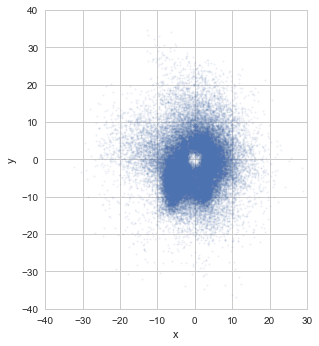

In [30]:
df.plot(kind='scatter', x='x', y='y', alpha=0.10, s=2)
plt.gca().set_aspect('equal')

## 2.2. Overview by Direction

In [31]:
if len(effective_column) == 16:
    rebinned_angle = 22.5
else: 
    rebinned_angle = 10

In [32]:
original_incre, incre = SECTOR_LENGTH, rebinned_angle
start, end = -original_incre/2 + incre/2, 360

max_speed = df.speed.max()
max_count = max_count_for_angles(df, start, end, incre)
plot_range = [0, max_speed, 0, max_count*1.05]

for angle in arange(start, end, incre):
    start_angle, end_angle = angle-incre/2, angle+incre/2
    sub_df, sub_max_speed = select_df_by_angle(df, start_angle, end_angle)   
    
    fig = plt.figure()
    title ='%s (%s - %s), %s' % (angle, start_angle, end_angle, len(sub_df)) 
    sub_df['speed'].hist(bins=arange(0, max_speed), alpha=0.5, label='Data')
    plt.axis(plot_range)
    plt_configure(figsize=(3,1.5), title=title)
align_figures()

D:\ProgramData\Anaconda3\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<img style="margin:0" align="left" src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAM0AAAB6CAYAAAAcc9ekAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAALEgAACxIB0t1+/AAAENRJREFUeJzt3WlQU9f/BvAnJIIUFGyp6K8WKyA4LkDcqHWrIxUtUlGR
WkA7pbXCtCPUqQWVuBErrh3rIIpoS7EWMyiMU+s+ilNtdETUqq0a3EU0tGJBlpBw/i8Y7t9ISHI1
kpvw/czw4h5O7v0SeLjbuScixhgDIcRsDtYugBBbQ6EhhCcKDSE8UWgI4YlCQwhPFBpCeLKr0DQ0
NGDZsmUIDg5GcHAwVq1aBZ1OZ7H+AFBdXY3w8HBUVla22mfRokXw9/fX+1q2bFmr/a9du4aYmBgE
BgYiLCwMx48fN/3DmvDpp5+2qGHr1q2t9j9z5gwmT56MgIAATJ06FX/++Sf3vYMHD2L+/Pm8a/j5
558RGhoKqVSK+Ph43Llzx2C/X3/9FVOmTGl1PVevXkX//v1x6tQp3jW8FMyOpKens/fee4+VlJSw
EydOsOHDh7OMjAyL9WeMsbS0NLZp0yajfaZPn842btzIHj58yH1VVVUZ7FtbW8tGjRrFZDIZU6lU
LCMjgw0YMIDdvHnT9A9sxMiRI1lBQYFeDTU1NQb7lpeXM6lUytavX89UKhVbsmQJCw4OZo8fP+b6
TJ06lZ06dcrs7efn57N+/fqxHTt2sNLSUiaXy9mYMWNa1PD777+zwMBANnnyZIPr0Wq1bMqUKczP
z48plUqzt/8y2U1o6urqWGBgIDt8+DDXtnv3bjZs2DCm0+leuD9jjD18+JAFBQWxyspKo7UMHTqU
FRUVmVV3QUEBGzZsGNNoNFxbbGwsS09PN+v1hlRVVTE/Pz+mUqnM6r9hwwYWERHBLTc2NrKxY8ey
3NxcvTpjY2PNrmHixIksLS1Nb53jx49nCoWCa0tPT2f9+vVjEydObDU0mZmZLCYmRlChsZvDs7/+
+gu1tbUYOnQo1zZ48GD8888/uH379gv3B4CdO3dCKpXCzc2t1TrUajUqKyvRq1cvs+o+e/YspFIp
OnTowLUNGTIEJSUlZr3eEJVKBYlEAi8vL7P6l5SUYMiQIdyySCTCoEGD9GoYM2YMSkpKcOXKFbPW
eefOHQwcOFBvnf7+/jh79izXplQqkZOTg3Hjxhlcx7Vr15CTk4OlS5eatc22YjehefDgAZydndGp
Uyeu7fXXXwcAlJeXv3B/ADh27BhGjhxptA6VSgWRSIQtW7Zg9OjReP/997Ft2zY0NjYa7P/w4UN0
7dpVr83DwwMPHjwwuh1TNbi6uiIlJQUjRozApEmTUFBQ0Gp/c2pwc3PDgAEDUFRUZFYNHh4eLd7H
srIy/Pvvv9xyQUEBBg0aZPD1Op0OKSkpSExMRLdu3czaZluxm9DU1tbCyclJr83R0REAoNFoXri/
TqfD5cuX4evra7SO69evw8HBAV5eXsjKykJcXBwyMjKQnZ3Nq25DNZirtLQUdXV1GDZsGLKzsxER
EQGZTIa9e/e+UA2+vr64ePGiWTWEh4dj69atuHDhArRaLRQKBS5duoSGhgazXp+dnQ1XV1d8+OGH
ZvVvSxJrF2ApHTt2bPFLbl52dnZ+4f6VlZXQ6XTo0qUL1/bZZ5+huLiYW967dy+io6MRFhYGd3d3
AIC/vz8eP36MH3/8EZ9//rnZdXTs2NHgzxkWFoaysjJu2dBh3Ndff434+HjuMLJPnz64c+cOcnNz
ERYW9tw1uLu74/r16wbrelZ8fDzKy8sxffp0AMA777yDiIgIVFVVmXytSqXCtm3bkJ+fD5FIZNb2
2pLdhKZbt26oqalBdXU1XF1dATSdXwCAp6fnC/dv/uU9fZi1fPly1NXVcctdu3aFSCTiAtPM19cX
FRUV0Ol0EIvFet/z9PTktttMrVYbrAEAsrKyoNVqDX6vmVgsbnHe5ePjg2PHjhnsb24NOp0ODg7m
HZw4OTlhxYoVWLRoEWpra/Hqq68iMTERPXr0MPna/fv3o6qqCh988IFe+6xZsxAREWH08n1bsJvQ
9OnTB87OziguLsbo0aMBNN178PDwMHhCzLd/ly5dIJFI8OjRI67N0B/28uXLoVKp8MMPP3BtFy9e
xFtvvdUiMAAglUqxdu1aaLVaSCQSrg6pVGrw53zjjTeMvQ0AgC+//BJubm5Yvnw513bp0iV4e3sb
7C+VSvUCxRjD2bNnERcXp9fv0aNH3HmfKWvWrEH37t0RExMDZ2dn1NbWQqlUYs2aNSZfGxsbi/Dw
cG65trYWkyZNglwux/Dhw83a/stkN+c0HTt2RGRkJJYtW4bi4mL88ccfWLt2LWbOnMn1qays5G5K
mtP/aSKRCH379jV59SgkJARKpRJZWVm4ffs2CgsLkZ2djYSEBABN/63VajW3h2q+ciSTyVBaWorM
zExcuHCBO6x5HiEhISgsLMSuXbtw+/Zt5OTkYM+ePYiPjwfQdOilVqu5Q7LIyEioVCqsW7cOpaWl
SEtLw5MnT/T+cAHgypUrGDBgAACgrq4OarW61ZvB3bt3R0ZGBk6fPo3S0lIkJiaiV69eGDFihMn6
3d3d0bNnT+7rzTffBND0T+q111577vfFUkSMWe8htKfPByxBo9EgJycHSqUSHTp0wKhRozB9+nTu
kCItLQ1A0x+oOf2ftXv3bly7dg3JyclG6zh9+jR2796N+/fvo0uXLggPD8fYsWMBNB32JCYmYvbs
2dwe7ubNm9i2bRtu3boFT09PxMbGIiAg4IXei8OHD2Pfvn2oqKiAp6cnpk2bxl1Wvnz5MuRyOVJT
U9G3b18ATXvDn376CQ8ePICXlxc++eQTvT1TTU0NZs+ejVWrVqF79+4oKirC5s2bsX79eoN7n8bG
RigUChQVFaGhoQFBQUH4+OOP9a5WNsvPz0dJSYnenvFpdXV1iIuL06u3LbR2Zc+qNzfPnDljzc3z
cubMGVZeXs4CAwOZWq22djkmWfq9zcvLYzNnztRrmzVrlkXeCyH+HRiryW4Oz9qCp6cnJk+ejJ07
d1q7lDbFGMMvv/zCHWICTTdlHRwc4OHhYcXKrINCw9PcuXPx22+/GR2waW/2798PPz8/vP3221xb
QEAAMjMzrViV9djN1bO20qlTp1ZvEtqrCRMmYMKECXptzVf62iPa0xDCE4WGEJ4oNITwRKEhhCcK
DSE8UWgI4cnkdUOdTofU1FTcuHEDIpEIS5cuhZOTE1JSUiASidC7d28sXrwYDg4OUCgUyMvLg0Qi
QUJCAsaMGdMWPwMhbcpkaI4ePQoAyMvLw6lTp/Ddd9+BMYakpCQEBwdj0aJFOHLkCIKCgpCbm4td
u3ahvr4e0dHRGD58OPdgFyH2wmRoQkJC8O677wJoely1c+fOOHnyJPds/ahRo3DixAk4ODhAKpXC
0dERjo6O8PLywt9//21y4KGlB22+TLZUK2Bb9dpSrWbd1pVIJEhOTsahQ4fw/fff48SJE9xDWS4u
LqiqqkJ1dbXeCFYXFxdUV1ebXHerI0kFpri42GZqBWyrXiHWaizEZl8IWLlyJQ4cOACZTIb6+nqu
/cmTJ+jcuTNcXV3x5MkTvXZDw8AJsXUmQ1NYWIjNmzcDaHp2XiQS6c12ePz4cQwePBgBAQEoLi5G
fX09qqqqUFpaCj8/v5dbPSFWYPLwbNy4cZg/fz5iYmKg1WqxYMEC+Pj4QCaTYd26dfD29kZoaCjE
YjFmzJiB6OhoMMbw1VdftZjhhBB7YDI0r7zyCtavX9+iffv27S3aoqKiEBUVZZnKCBEourlJCE8U
GkJ4otAQwhOFhhCeKDSE8EShIYQnCg0hPFFoCOGJQkMITxQaQnii0BDCE4WGEJ4oNITwRKEhhCej
jwY0NDRgwYI

## 2.3 Overview by Month

In [33]:
month_incre = 1
current_df = df.query('speed>=1')
for month in arange(1, 12+month_incre, month_incre): 
    end_month = month+month_incre
    sub_df = current_df.query('(month >= @month) and (month < @end_month)')
    if len(sub_df) > 0:
        if month_incre == 1:
            title = 'Month: %s' % (month)
        else:
            title = 'Month: %s - %s ' % (month, end_month-1)
        ax = WindroseAxes.from_ax()
        ax.bar(sub_df.dir_windrose, sub_df.speed, normed=True, opening=0.8, edgecolor='white', nsector=36, cmap=plt.get_cmap('viridis'))
        plt_configure(figsize=(3,3), title=title)
align_figures()

D:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


<img style="margin:0" align="left" src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAOwAAADxCAYAAADIm1tRAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAMTQAADE0B0s6tTgAAIABJREFUeJzsnXd4HOW1xn/bu1ZbtOqSVSzJkjsuuABuYAMBE0qAUHIJ
CZcbOiFAAsSEGkICoaSHQCCEFqpDC2Cawca4xLZ673Wl1fa+c/8Qu1i4SfZIlkHv8+ixd3fmm9nZ
eec73ynvkQiCIDCJSUziqID0SJ/AJCYxiZFjkrCTmMRRhEnCTmISRxEmCTuJSRxFmCTsJCZxFGGS
sJOYxFGEScJ+AzAZufv6YJKw44AVK1ZQXFzML3/5y31+3tHRQXFxMcXFxQwMDIh67HfffZd169Yl
Xj/yyCPMmTNH1GN4PB6WL1/OW2+9Jeq4k9gbk4QdJ0gkEt555519fvb222+P2XH//ve/09PTM2bj
ezwefvSjH9HZ2Tlmx5jEl5gk7Dhhzpw5tLe3U1lZuddnb731FsXFxUfgrA4PW7Zs4ZxzzqG6uvpI
n8o3BpOEHSdMmzaN7OzsvWbTzs5Odu/ezZo1a/ba55133uGss85i9uzZnHDCCfz2t78lEokkPl+x
YgV/+ctfWLduHQsWLGDu3LncdNNNeDweAC666CK2bNnCBx98QHFxMe3t7Yl933jjDVavXs2MGTM4
88wz2b59e+Kz9vZ2iouLeeSRRw74na644gqKior461//ekjXZBKjxyRhxxEnnXTSXmbx22+/zaxZ
s0hLSxv2/nPPPceVV17JzJkzefTRR7nwwgv529/+xs033zxsuz/96U+4XC4eeOABrr32Wl5//XX+
8Ic/ALBu3TpKS0uZO3cuzz33HDabDQC/38+DDz7I1VdfzUMPPYTf7+eqq65KPAxsNhvPPfcc55xz
zgG/z9NPP81DDz2E2Ww+rOsyiZFDfqRP4JuENWvW8Nhjj9HQ0EBBQQEwZA6ffPLJw7aLRqP89re/
5dRTT004jJYuXYrBYGDdunX84Ac/oKSkBIC0tDQeeOABJBIJS5cu5cMPP+Svf/0rCxYs4IQTTkCv
16PVarn++ut58skngSGv8f3338/s2bMBiEQiXHXVVdTX11NSUoJSqUx8diAUFRWJdm0mMTJMzrDj
iBkzZpCens5//vMfALq6uti1axerV68etl1jYyMDAwN7mcmnnnoqAFu3bh02pkQiSbxOSUkBhmZX
t9u9z/OQyWTMnDkz8TozMxNgv9tPYuJgkrDjCIlEMswsfvvtt5k5cybp6enDtnM6nQBYLJZh7xsM
BpRKZWKNCqDRaPY6hkwmY+nSpdx77737PA+VSoVU+uVPH/9/LBY7xG82ifHCJGHHGSeddBIVFRW0
t7fz9ttv72UOAyQnJwPQ398/7H2Xy0UoFEp8fiDcfPPNbNq0icHBQXFOfBITApOEHWfMnTuXlJQU
nn32WXbu3LmXOQyQl5eHyWTaKxHhjTfeSIxxMOj1eu68806am5uHeZYncXRj0uk0zpBKpZx44ok8
8cQTiTXtVyGTybjyyiu58847MRqNrFy5kpqaGh555BHWrFkzYmfP0qVLSUlJYceOHWg0GoLB4Ij2
C4VCVFZWkpaWtpf3ehJHFpMz7BHASSedRDgc3mfsNY4LL7yQu+++m88++4zLL7+cp59+mksuuYRf
//rXozrWHXfcgd/vx263U19fP6J9ent7Offcc3nhhRdGdaxJjD0kk5pOXy+0t7dz8cUXs2HDhsR7
Gzdu5NJLL+W9994jKyvrCJ7dJA4Xk4SdxCSOIkyaxJOYxFGEScJOYhJHESYJO4lJHEWYDOt8DRCL
xYhGowllCUEQEv+XSCTD/mQy2bBUxvHGM888w7PPPpt43dnZybJly7j//vsT77W3tyeqjgwGA/fd
d18iffKbjkmn0wSGIAiEw2FCoRDhcDjxFwwGE+9FIpFRpxTKZDIUCgUKhQKlUolSqUy8VigUqFQq
5PKxf5Y3NTVx6aWX8swzz5Campp4/yc/+QmzZ8/mggsu4KmnnmLnzp2jDmd9XTE5w04QCIJAKBTC
5/Ph9Xrxer34fD5isRhSqTTxJ5fLkcvlaDQajEYjKpUqQbo4yaRSKdFolP/+97/Mnj0biUSCIAhE
IhFCoRDBYDBB+vgx48SPxWIIgoBCoUCr1SaqfbRaregkvuOOO7j66quHkRWGLAav1wtAIBBArVaL
etyjGZOEPUKIRCK43e69yCmXy1EoFGg0GiwWC0ajEYVCcVjHiif3y2QyVCoVBoNhv9sKgoDf78fp
dOL1erHb7YTDYWKx2DAS63Q69Hr9IZvXW7duxW63s3bt2r0+u+aaazjvvPN46qmniEQiw0zobzom
CTuOCAaDDA4O4nA48Hq9CdNUq9WSkpKC0WhEJpMd0XOUSCSJGXVPhEIhHA4HLpeLvr4+Ojs7kUgk
GI1GkpOTR33uzzzzDJdccsk+CX/TTTdxxx13sGrVKt5++22uvPJKXnvttSO69p4omFzDjiEEQcDn
8+FwOBgcHCQYDKJQKNDr9aSkpBxwpjtc7GkSj8VDIBaLMTAwQH9/P36/n2g0ik6nw2w2J0z1/SEc
DnP88cfzzjvvoNfrh302MDDAySefzGeffZZ479hjj+WNN96YVLZgcoYVHYIgJEzJwcFBYrEYKpWK
5ORkUlNTD9u8nSiQSqVYrVasVisAXq+X3t5euru7aWtrQ6VSYTKZSElJQalUDtu3traW3NzcvcgK
YDKZUKlUfPbZZyxcuJBt27ah1WoxmUzj8r0mOiYJKxKi0SgOh4Oenh6CwSAqlYq0tDRsNtuwYvGv
K3Q6HXl5ecCQ6d/T00N/fz/d3d0YjUZsNhsGgwGJREJra+teVUq33HILK1asYOXKlTz66KPceeed
BAIBdDodDz/88KQ5/AUmTeLDRCAQoLe3F7vdjlQqJTk5mczMzCM+k461STxSeDweOjo68Hq9yOVy
UlNTsVgs4xI2+jpi8qodAgRBYHBwkJ6eHrxeL2q1mtzcXMxm8+RM8BXo9XqKi4uJRqN0dXXR3d1N
R0cHZrMZm822l3NrEgfG5Aw7CgiCwMDAAB0dHUSjUfR6PdnZ2RMyTjhRZth9weFw0NnZSSAQQK/X
k5WVhU6nO9KndVRgcoYdAQRBwOVy0dbWRjgcxmQykZ2dPeGIcLTAZDJhMpnw+/20tLRQXV2dWEpM
xIffRMIkYQ8Cj8dDW1sbfr+f5ORkcnNzJ4kqEjQaDSUlJfj9fpqamqioqMBisZCRkbGXZ3kSQ5gk
7H7g9/tpb2/H7XZjMBiYMWPGEXckfV2h0WgoLS3F4/HQ3NxMeXk5NpuNtLS0SefUVzB5Nb6CSCRC
W1sbAwMDaLVapk2btpf27yTGBnq9nunTpzMwMEB7ezt9fX2kp6eTmpo66cz7ApOE3QMOh4OWlhak
UilTp04lKSnpSJ/SNxJmsxmz2UxnZyddXV0MDAyQn58/ub5lkrDA0Kza0tKC0+kkJSWFzMzMb0Sy
w0RHRkYGNpuN+vp6KisrycjI+MbPtt94wjocDpqbm1EoFJPmr4jYsGEDjz76KD6fj6VLl3LrrbcO
+3zTpk3cd999RKNRMjMzue+++zAajXuNI5fLKSkpwW63J5Yq3+TZ9hs7jUQiERoaGmhqasJms1FW
VjZJVpHQ1tbGunXr+P3vf8/69euprKzkgw8+SHwejUa56aab+M1vfsP69espLCzkscceO+CYVquV
mTNnIpPJqKyspLu7m29iCsGEIWy8ifCHH3447P0VK1YMa0QcDoeZM2cOAwMDifcuuugizjrrrMRr
p9PJnDlzCIVC+zyWw+GgvLwcn8/HtGnTyMzMPKrNLEEQiMVihEIhAoFA4g9I/D9e0zoeeOeddzjl
lFNIS0tDoVD

## 2.4 Month Accumulation

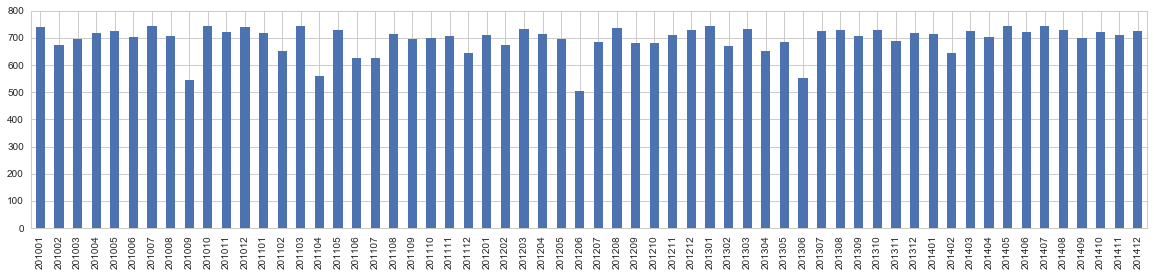

In [34]:
df['date'].apply(lambda x: str(x)[:-2]).value_counts().sort_index().plot(kind='bar', figsize=(20,4))

## 2.5 Create input data, i.e. speed_set

In [35]:
SPEED_SET = array(list(zip(df.x, df.y)))
NUMBER_OF_GAUSSIAN = 3
FIT_METHOD = 'square_error'
DEFAULT_BANDWDITH = 1.5 if knot_unit else 0.7
fig_list = []

In [36]:
fit_limit = ceil(df['speed'].quantile(.95))
fitting_axis_range = arange(-fit_limit, fit_limit+1, 1)
print(fitting_axis_range)

FITTING_RANGE = []
for i in fitting_axis_range:
    for j in fitting_axis_range:
        FITTING_RANGE.append([i,j])

[-18 -17 -16 -15 -14 -13 -12 -11 -10  -9  -8  -7  -6  -5  -4  -3  -2  -1
   0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18]


In [37]:
plot_limit = ceil(df['speed'].quantile(.95))
PLOT_AXIS_RANGE = arange(-plot_limit, plot_limit+1, 1)

# 3. Kernel Density Estimation

In [38]:
sample = SPEED_SET
KDE_KERNEL = 'gaussian'
# KDE_KERNEL, bandwidth = 'tophat', 1

In [39]:
%%time
from sklearn.grid_search import GridSearchCV
# from sklearn.model_selection import GridSearchCV  ## too slow

# The bandwidth value sometimes would be too radical
if knot_unit:
    bandwidth_range = arange(0.7,2,0.2)
else:
    bandwidth_range = arange(0.4,1,0.1)

# Grid search is unable to deal with too many data (a long time is needed)
if len(sample) > 50000:    
    df_resample=df.sample(n=50000, replace=True)
    bandwidth_search_sample = array(list(zip(df_resample.x, df_resample.y)))
else:
    bandwidth_search_sample = sample

grid = GridSearchCV(neighbors.KernelDensity(kernel = KDE_KERNEL),
                    {'bandwidth': bandwidth_range}, n_jobs=-1, cv=4) 

grid.fit(bandwidth_search_sample)
bandwidth = grid.best_params_['bandwidth']
print(bandwidth)

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


1.1
Wall time: 2min 16s


In [40]:
if 'bandwidth' not in globals():
    bandwidth = DEFAULT_BANDWDITH

kde = neighbors.KernelDensity(bandwidth=bandwidth,kernel = KDE_KERNEL).fit(sample)

points = FITTING_RANGE
# very slow if the dataset is too large, e.g. 100,000
# kde returns log prob, need to convert it
kde_result = exp(kde.score_samples(points))
print('bandwidth:', bandwidth, len(kde_result))
print(kde_result[:5])

bandwidth: 1.1 1369
[  1.16299871e-05   1.35473034e-05   1.49476094e-05   1.50171188e-05
   1.35674492e-05]


In [41]:
# Plot jPDF
X = Y = PLOT_AXIS_RANGE
# Can't work if pass as generate_Z_from_X_Y(X,Y, exp(kde.score_samples())), need to use lambda
# see http://stackoverflow.com/questions/21035437/passing-a-function-as-an-argument-in-python
kde_Z = generate_Z_from_X_Y(X,Y, lambda coords: exp(kde.score_samples(coords)))
colorbar_lim = 0, kde_Z.max()

plot_3d_prob_density(X,Y,kde_Z)

fig_kde,ax1 = plt.subplots(figsize=(4,3))
plot_2d_prob_density(X,Y,kde_Z,xlabel='x', ylabel='y',ax=ax1)

with sns.axes_style({'axes.grid' : False}):
    from matplotlib import ticker
    fig_hist,ax2 = plt.subplots(figsize=(4,3))
    _,_,_,image = ax2.hist2d(df.x, df.y, bins=PLOT_AXIS_RANGE, cmap='viridis',)
    ax2.set_aspect('equal')
    cb = plt.colorbar(image)
    tick_locator = ticker.MaxNLocator(nbins=6)
    cb.locator = tick_locator
    cb.update_ticks()
    plt_configure(ax=ax2, xlabel='x',ylabel='y')
align_figures()

<img style="margin:0" align="left" src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAATkAAAE5CAYAAADr4VfxAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAALEgAACxIB0t1+/AAAIABJREFUeJzsvXmUK3d9J/oplfatN/W+ty7GwQ7ENobJc5gkN3gIfiQn
xGFxJpkBTLY3g5OBvNgYnDgxxjZJTBYzzgBxyODJM8QzZ3IY8s4jLIGEkwSM8SS2cYK7+3a3urVL
rV0q1fL+UP+qf1WqKlVJpW6pXZ9z7rn3dlf96iep6qPPd2ckSZLgwIEDBxcUrvPegAMHDhwMEw7J
OXDg4ELDITkHDhxcaDgk58CBgwsNh+QcOHBwoeGQnAMHDi40HJJz4MDBhYZDcg4cOLjQcEjOgQMH
FxoOyTlw4OBCwyE5Bw4cXGg4JOfAgYMLDYfkHDhwcKHhkJwDBw4uNBySc+DAwYWGQ3IOHDi40HBI
zoEDBxcaDsk5cODgQsMhOQcOHFxoOCTnwIGDCw2H5Bw4cHCh4ZCcAwcOLjQcknPgwMGFhkNyDhw4
uNBwSM6BAwcXGu7z3oCD84ckSeA4DjzPg2VZeDweuFwuMAxz3ltz4GBgMJIkSee9CQfnh1arhVKp
hEgkgna7DQA4OjrC1NQUIpEIXC6XQ3oOxhqOknsJQxAENBoNZLNZhEIh8DwPj8cDSZIgSRIEQQDP
8+A4DgzDgGVZh/QcjB0cknsJQpIk8DwPQRDAMAwEQcD29jYEQYDb7YYoiqjX6/D5fHC7T28RQnqt
Vgsulwssy4JlWbjdbof0HIwsHHP1JQZRFNFut0E+9mQyiUKhgLW1NXi9XnAch1QqBYZh0G634Xa7
EQwGEQgEEAwGwbKsYj2yDsMwMtm53e6u4xw4OC84Su4lAmJ+CoIAAOB5HolEAqIowuPxIBKJgOM4
+P1+eDweTExMIBQKodVqoV6vo1QqIZ1Oy6RHiI8mM57nIUkSWq0WMpkM5ufn4fV6HdJzcK5wSO4l
AFEUwfM8RFEEwzCoVCo4PDzE9PQ0otEo9vf3FcczDANJksAwDPx+P/x+P6anpyFJEprNJhqNBo6P
j5FKpeDxeGTCo0mvVquB4ziZ9Ih56yg9B2cNh+QuOIgfjQQTUqkUyuUyVldXZaVm1mPBMIxMZjTp
1et1HB8fI5lMwuv1IhgMQpIkmVSBUz+gQ3oOzhoOyV1QiKIIQRAgiiIAgOM4HBwcwOv1Ih6PywGF
QYIFNOmRaxKlJ4oiDg4O4PP5ZH9eIBCAy9XJP3dIz8FZwSG5CwhRFJHL5VAqlbC2toZisYhUKoW5
uTlMT093EZtayRFz1SpcLpfsryuXy1hcXJQjtYVCAc1mEz6fT2HeGpFetVpFNBqFz+dzSM9B33BI
7oKBmKdAhzgSiQQajQY2Nzfh9/u7jh9m2ofL5YLf70cwGATQId9Go4FGo4F8Po9WqwW/3y8rPb/f
ryC9TCYDt9sNnucdpeegbzgkd0Ggzn1rt9uoVquYnJxEPB6XyUPvXGC4hAd0SC8UCiEUCgE4Jb16
vY5cLieTHlF6JPhBlKWeeev1ep0cPQe6cEjuAkCd+5bL5ZDJZOD1erG8vGx4rhY59GuuWoWa9EgF
BqnC4HkeqVQKoVBIVnq9Ahmk9tYhPQcEDsmNOYh6AzokcXh4CJ7nsbCwgHK5bGqNUckHZ1kW4XAY
4XAYALCzs4NoNAqO45DJZNButxVKT4v02u02ms2mTHoMw8Dj8Tjm7UsYDsmNKdTmabVaRSKRwOTk
JNbW1lCr1UyRl57isYP4Bl2DYRgEg0FMTk4COFV69Xod6XQaPM/LpBcMBuHz+bpIL5lMyms4Su+l
CYfkxhB07hsApNNpFItFLC8vIxKJyMf1SzJ2EMAwSESt9Hiel0kvlUqB53lFuorP55P3oqf0HNK7
+HBIbowgSRLy+Tw8Hg/8fj/a7TYSiQQYhkE8HofH45GPNfvQnpX/bRhwu92IRCIysdOkd3x8DEEQ
5ICLz+dTBCho0iM+PUJ8DuldLDgkNyYgpVnFYlH2Ux0eHiIWiyEWi3U9lIOS1zgSnxbpHR0dyX8L
gqBoNkCTniiKcgCHJj232w232+2Q3hjDIbkxgCAIckNLACgWi+A4Duvr63IOWr+g61Tpn10EEIIi
xNdutxVKTxRFmfCCwaBCwdGk1263UalUMD8/75DeGMIhuRGGOrjQbDZRrVbh8/lw6dIlw4jhOJuh
w4LH44HH40E0GgUAtNtt1Ot1NBoNFAoFSJKkUHqE9HieR71el81bhmEcpTdGcEhuREF3DgGAQqGA
dDoNv9+PiYmJnikRZkmO9lFZPXfcQVpKTUxMQJIkhdIrFAoAgEAgIDcSpRUvrfQc0httOCQ3gqBz
30RRxNHREZrNJjY3N+WH76UAu9JYzBAOwzDwer3wer0K0qvX66hUKmi1Wtjd3dVUeoBDeqMMh+RG
CGrztF6v4+DgAJFIRC7NsqLQrLRQGoZys2PN8yIHmvQ8Hg8KhQLm5+dRr9dRq9WQy+XgcrkUKSt6
pAd00l9IMjOdz+dg+HBIbkSgzn3LZrPI5XJYWlrCxMREX2sOkidnRyLvRYEkSXKNrNfrxeTkpDzG
sV6vo1qtIpPJgGVZRSCDVnCiKCKTySAUCiESiSiGApHKDAfDgUNy5wxJklCr1ZBMJrG2tgZBEOS2
5PF4HF6vV3G8VV+bGVxkH5xZc9UqGIaBz+eDz+fD1NSUgvQqlYpMenSreLrhgJbSI0OBHNKzFw7J
nSNIcIFMwCJtyaempjA3NzdQ8fxFJq6zhhmi1CK9VquFRqOBcrmMdDotd0sGTgMaavOW4zgA6BoK
5JBe/3BI7pxAm6ekNdLh4SFWVlbksiUtWCEvKySXy+VQLpfh9/vl0YQOOujny4Kej0FIb39/H263
u2soED0JjZAZGTqknnnrkJ51OHfyGUOr71sikYAkSbh06ZIpcrHTXCVpKpVKBXNzc3IKRbVaRaPR
UJhbRj3pRhV2mauDrkEirtFoVJ6BQVrFl0olpFIpeL1eRSBDj/SSySQWFxcVk9Ac0tOHQ3JnCPXU
rFKphKOjI0xPT8szTnvBzppUEr1lGAZra2vyzAZiVoXDYc3W5eouvhcdw/DrWRkKRE9CYxgGjUZD
roJxlF5vOCR3RqBz3yRJwtHREWq1GjY2NuQUBTOww9dGCv2z2SyWl5dxdHSkWdZFHq6ZmRlFF99s
NguO4xSRRK20CMcnqIQRWRoNBSoWi0gmk/JQIJKYTM4DHPPWCA7JDRlapVkHBwcIBAKIx+NgWRaC
INie06Z3HM/zcmNNEr09OjrqqVb0uvhqtTki5tgo4CwTiu1chx4KRL5kiNKTJAlXrlzRHApEkx7P
8w7pwSG5oUJdWJ/P55HJZLCwsICpqSn558NI3NU6jpin0WgUq6ursrnZzw2v1dutXq+jXq+jWCyC
53nk83lEIhG5OsAq7CLKUXmgByFLmvQKhQK2trbQarVQr9d7DgUCtEmv1WohHA5f+IoMh+SGAEmS
IAgCnnvuOVy6dAkAcHR0BI7jsLW1JTdzJLBqglp9+NXmKSlQVx9DbvR+TGK3241oNIpoNApJkrC3
twefzycPqSEPKXkIxyl6O6xcu35APhea9AD9oUBGpHflyhWsr6/LCckkOZlWhBcB43OnjQnUhfW1
Wg2pVArRaBQrKys9p2aZyccyA3Kclnna75pmQSKJ4XBYDmSoE2VJ+gQdSTR6Hf1iVMxmwB6ypBOK
aRhNQiM+VLpVvN/vhyRJ8vuupfRIcvK4k55DcjZCXZpFiuv11BMBuWnNkpyVB3d7exuRSERhnmpB
vaad5KCVKKuOJA4zcmsXsQwKO0muF4wmoWUyGXAcB0mSUCwWuyahkeN5nu9qFT+OpOeQnA0g5inP
83L/MZL7tra

In [42]:
kde_cdf = cdf_from_pdf(kde_result)

# 4. GMM by Expectation-maximization

In [43]:
sample= SPEED_SET
clf = mixture.GaussianMixture(n_components=NUMBER_OF_GAUSSIAN, covariance_type='full')
clf.fit(sample)
print(clf.converged_)

True


In [44]:
gmm_em_result = read_gmm_em_result(clf)
pretty_print_gmm(gmm_em_result)

weight  mean_x  mean_y  sig_x  sig_y    corr
1  0.354   3.433  -2.182  3.181  6.746   0.095
2  0.328  -4.894  -4.625  2.258  4.481   0.053
3  0.317  -1.632   2.150  8.157  8.435  -0.047

GMM Plot Result
0.354308811934 [[ 3.43268529 -2.18160773]] [ 3.1619438   6.75521007] 176.699299605
0.328231307245 [[-4.8944056  -4.62455535]] [ 2.25370039  4.48348023] 177.959159525
0.317459880821 [[-1.63246768  2.14959496]] [ 8.05358389  8.53375945] -152.666212243


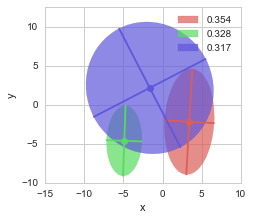

In [45]:
fig,ax = plt.subplots(figsize=(3.5,3.5))
plot_gmm_ellipses(gmm_em_result, ax=ax)

In [46]:
X = Y = PLOT_AXIS_RANGE
pdf_Z = generate_Z_from_X_Y(X,Y, lambda coords: exp(clf.score_samples(coords)))

def residule_between_kde_and_gmm(points):
    kde_vals = exp(kde.score_samples(points))
    gmm_vals = exp(clf.score_samples(points))
    return kde_vals - gmm_vals 

residual_Z = generate_Z_from_X_Y(X,Y, residule_between_kde_and_gmm)

plot_3d_prob_density(X,Y,pdf_Z)
plot_3d_prob_density(X,Y,residual_Z)
align_figures()

fig = plt.figure(figsize=(4,3))
plot_2d_prob_density(X,Y,kde_Z,xlabel='x',ylabel='y', colorbar_lim=colorbar_lim)
fig_em = plt.figure(figsize=(4,3))
plot_2d_prob_density(X,Y,pdf_Z,xlabel='x',ylabel='y', colorbar_lim=colorbar_lim)
fig = plt.figure(figsize=(4,3))
plot_2d_prob_density(X,Y,residual_Z,xlabel='x',ylabel='y')
align_figures()

<img style="margin:0" align="left" src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAATkAAAE5CAYAAADr4VfxAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAALEgAACxIB0t1+/AAAIABJREFUeJzsvXmUM2d9LviUSvvWm3rfuz8DiX0xNktOhkAmDg7BAznh
GjDOJBkIS5hJIBmSczAGE9/YBpPFZAZ7fCcGwx2cxDhMZrgecs8EMBNfuAmbY7h4IXy9Sq2ltbV2
qVTL/KF+364qVZWqpNLXUruec3zcX3fVW6+kqkfPb2ckSZLgwIEDBxcUrvPegAMHDhwMEw7JOXDg
4ELDITkHDhxcaDgk58CBgwsNh+QcOHBwoeGQnAMHDi40HJJz4MDBhYZDcg4cOLjQcEjOgQMHFxoO
yTlw4OBCwyE5Bw4cXGg4JOfAgYMLDYfkHDhwcKHhkJwDBw4uNBySc+DAwYWGQ3IOHDi40HBIzoED
BxcaDsk5cODgQsMhOQcOHFxoOCTnwIGDCw2H5Bw4cHCh4ZCcAwcOLjQcknPgwMGFhkNyDhw4uNBw
SM6BAwcXGu7z3oCD84ckSeA4DjzPg2VZeDweuFwuMAxz3ltz4GBgMJIkSee9CQfnh1arhVKphEgk
gna7DQBIJpOYmppCJBKBy+VySM/BWMNRci9gCIKARqOBbDaLUCgEnufh8XggSRIkSYIgCOB5HhzH
gWEYsCzrkJ6DsYNDci9ASJIEnuchCAIYhoEgCNjZ2YEgCHC73RBFEfV6HT6fD2732S1CSK/VasHl
coFlWbAsC7fb7ZCeg5GFY66+wCCKItrtNsjHnkqlUCgUsLa2Bq/XC47jkE6nwTAM2u023G43gsEg
AoEAgsEgWJZVrEfWYRiGkp3b7e46zoGD84Kj5F4gIOanIAgAAJ7nkUgkIIoiPB4PIpEIOI6D3++H
x+PBxMQEQqEQWq0W6vU6SqUSMpkMJT1CfHIy43kekiSh1Wrh+PgY8/Pz8Hq9Duk5OFc4JPcCgCiK
4HkeoiiCYRhUKhUcHR1henoa0WgUh4eHiuMZhoEkSWAYBn6/H36/H9PT05AkCc1mE41GAycnJ0in
0/B4PJTw5KRXq9XAcRwlPWLeOkrPwZWGQ3IXHMSPRoIJ6XQa5XIZq6urVKmZ9VgwDEPJTE569Xod
JycnSKVS8Hq9CAaDkCSJkipw5gd0SM/BlYZDchcUoihCEASIoggA4DgO8XgcXq8X29vbNKAwSLBA
TnrkmkTpiaKIeDwOn89H/XmBQAAuVyf/3CE9B1cKDsldQIiiiFwuh1KphLW1NRSLRaTTaczNzWF6
erqL2NRKjpirVuFyuai/rlwuY3FxkUZqC4UCms0mfD6fwrw1Ir1qtYpoNAqfz+eQnoO+4ZDcBQMx
T4EOcSQSCTQaDWxubsLv93cdP8y0D5fLBb/fj2AwCKBDvo1GA41GA/l8Hq1WC36/nyo9v9+vIL3j
42O43W7wPO8oPQd9wyG5CwJ17lu73Ua1WsXk5CS2t7cpeeidCwyX8IAO6YVCIYRCIQBnpFev15HL
5SjpEaVHgh9EWeqZt16v18nRc6ALh+QuANS5b7lcDsfHx/B6vVheXjY8V4sc+jVXrUJNeqQCg1Rh
8DyPdDqNUChElV6vQAapvXVIzwGBQ3JjDqLegA5JHB0dged5LCwsoFwum1pjVPLBWZZFOBxGOBwG
AOzu7iIajYLjOBwfH6PdbiuUnhbptdttNJtNSnoMw8Dj8Tjm7QsYDsmNKdTmabVaRSKRwOTkJNbW
1lCr1UyRl57isYP4Bl2DYRgEg0FMTk4COFN69XodmUwGPM9T0gsGg/D5fF2kl0ql6BqO0nthwiG5
MYQ89w0AMpkMisUilpeXEYlE6HH9kowdBDAMElErPZ7nKeml02nwPK9IV/H5fHQvekrPIb2LD4fk
xgiSJCGfz8Pj8cDv96PdbiORSIBhGGxvb8Pj8dBjzT60V8r/Ngy43W5EIhFK7HLSOzk5gSAINODi
8/kUAQo56RGfHiE+h/QuFhySGxOQ0qxisUj9VEdHR4jFYojFYl0P5aDkNY7Ep0V6yWSS/l8QBEWz
ATnpiaJIAzhy0nO73XC73Q7pjTEckhsDCIJAG1oCQLFYBMdxWF9fpzlo/UJepyr/3UUAIShCfO12
W6H0RFGkhBcMBhUKTk567XYblUoF8/PzDumNIRySG2GogwvNZhPVahU+nw+XLl0yjBiOsxk6LHg8
Hng8HkSjUQBAu91GvV5Ho9FAoVCAJEkKpUdIj+d51Ot1at4yDOMovTGCQ3IjCnnnEAAoFArIZDLw
+/2YmJjomRJhluTkPiqr5447SEupiYkJSJKkUHqFQgEAEAgEaCNRueKVKz2H9EYbDsmNIOS5b6Io
IplMotlsYnNzkz58LwTYlcZihnAYhoHX64XX61WQXr1eR6VSQavVwt7enqbSAxzSG2U4JDdCUJun
9Xod8XgckUiElmZZUWhWWigNQ7nZseZ5kYOc9DweDwqFAubn51Gv11Gr1ZDL5eByuRQpK3qkB3TS
X0gyszyfz8Hw4ZDciECd+5bNZpHL5bC0tISJiYm+1hwkT86ORN6LAkmSaI2s1+vF5OQkHeNYr9dR
rVZxfHwMlmUVgQy5ghNFEcfHxwiFQohEIoqhQKQyw8Fw4JDcOUOSJNRqNaRSKaytrUEQBNqWfHt7
G16vV3G8VV+bGVxkH5xZc9UqGIaBz+eDz+fD1NSUgvQqlQolPXmreHnDAS2lR4YCOaRnLxySO0eQ
4AKZgEXakk9NTWFubm6g4vmLTFxXGmaIUov0Wq0WGo0GyuUyMpkM7ZYMnAU01OYtx3EA0DUUyCG9
/uGQ3DlBbp6S1khHR0dYWVmhZUtasEJeVkgul8uhXC7D7/fT0YQOOujny0I+H4OQ3uHhIdxud9dQ
IPkkNEJmZOiQeuatQ3rW4dzJVxhafd8SiQQkScKlS5dMkYud5ipJU6lUKpibm6MpFNVqFY1GQ2Fu
GfWkG1XYZa4OugaJuEajUToDg7SKL5VKSKfT8Hq9ikCGHumlUiksLi4qJqE5pKcPh+SuINRTs0ql
EpLJJKanp+mM016wsyaVRG8ZhsHa2hqd2UDMqnA4rNm6XN3F96JjGH49K0OB5JPQGIZBo9GgVTCO
0usNh+SuEOS5b5IkIZlMolarYWNjg6YomIEdvjZS6J/NZrG8vIxkMqlZ1kUerpmZGUUX32w2C47j
FJFErbQIxyeohBFZGg0FKhaLSKVSdCgQSUwm5wGOeWsEh+SGDK3SrHg8jkAggO3tbbAsC0EQbM9p
0zuO53naWJNEb5PJZE+1otfFV6vNETHHRgFXMqHYznXkQ4HIlwxRepIkYX9/X3MokJz0eJ53SA8O
yQ0V6sL6fD6P4+NjLCwsYGpqiv5+GIm7WscR8zQajWJ1dZWam/3c8Fq93er1Our1OorFInieRz6f
RyQSodUBVmEXUY7KAz0IWcpJr1AoYGtrC61WC/V6vedQIECb9FqtFsLh8IWvyHBIbgiQJAmCIOCZ
Z57BpUuXAADJZBIcx2Fra4s2cySwaoJaffjV5ikpUFcfQ270fkxit9uNaDSKaDQKSZJwcHAAn89H
h9SQh5Q8hOMUvR1Wrl0/IJ+LnPQA/aFARqS3v7+P9fV1mpBMkpPlivAiYHzutDGBurC+VqshnU4j
Go1iZWWl59QsM/lYZkCO0zJP+13TLEgkMRwO00CGOlGWpE/II4lGr6NfjIrZDNhDlvKEYjmMJqER
H6q8Vbzf74ckSfR911J6JDl53EnPITkboS7NIsX1euqJgNy0ZknOyoO7s7ODSCSiME+1oF7TTnLQ
SpRVRxKHGbm1i1gGhZ0k1wtGk9COj4/BcRwkSUKxWOyahEaO53m+q1X8OJKeQ3I2gJinPM/T/mMk
921tbc0wuVe

<img style="margin:0" align="left" src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAQsAAADPCAYAAADiW/REAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAALEgAACxIB0t1+/AAAIABJREFUeJztnW1QVOcZ9//LAgFhFV+QEAVf0ESx+IJp7EyIfUpibZ1J
J45VJJbMkzBx+iF20qjxJVFMxJe01XxQayd2Mk/EWDH2g800k9aqLWPMpEELQVc0YEBUCqhod1FE
ln0+rPfh7OG83Ofs2T1n2es3szOw59zn3Lyc/17XdV/3dTn8fr8fBEEQGsRZPQGCIKIDEguCILgg
sSAIggsSC4IguCCxIAiCCxILgiC4iLd6AkY4c+aM1VMgCIHZs2dzn1tTcxw+X5ri8cTEROTl5Zkx
LdOJSrEAgMp3Tlo9hSA8Hg9cLpfV09AFzTl0isp+pOt8ny8NWdlbFY+3XFkf6pTCBrkhBEFwQWJB
EAQXJBYEQXBBYkEQBBckFgRBcEFiQRAEFyQWBEFwQWJBEAQXlohFbW0tSkpKAAButxvPPPMMSkpK
UFJSgs8++8yKKREEoUHEMzj37duHv/zlL0hOTgYAnD9/Hi+//DJeeeWVSE+FIAgdRNyyyM7Oxq5d
u4Tvz507h3/+859YtmwZ1q9fD6/XG+kpEURU0NfXh40bN6KoqAglJSVobm4OOn7ixAksWrQIRUVF
OHz4sOoYIxZ9xC2L+fPn4+rVq8L306dPx+LFi/G9730Pe/fuxZ49e7BmzRrN63g8nnBO0xB2nJMW
NOfo4R//+Ad6enpQWVmJmpoabN++HXv37gUAPHjwANu2bcORI0eQnJyM4uJiFBYW4uzZs7JjjFj0
lm8kmzdvHoYOHSp8vXnzZq5xdtpMBNhvgxMPNGdr6Oy5ZGjcmTNn8MwzzwAAZs6ciXPnzgnHGhsb
kZ2djWHDhgEI7IT9+uuvUVNTIzvm3Llz+O6773D8+HGMGzcO69evR2pqqur9LV8NKS0txTfffAMA
+PLLLzFt2jSLZ0QQ4aUFBYovNbxeb9AD7XQ60dvbKxwTi2hKSgq8Xq/imOnTp+PNN9/Exx9/jKys
LOzZs0dz3pZbFps2bcLmzZuRkJCAUaNGcVsWBBFrpKamoqurS/i+r68P8fHxsse6urrgcrkUxxix
6C2xLMaOHSsEYKZNm4ZDhw6hoqIC77//vqYpRBCxSn5+PqqqqgAANTU1ePzxx4VjOTk5aG5uxu3b
t9HT04Pq6mrMmjVLcYwRi95yy4IgCD7mzZuHL774AkuXLoXf78fWrVvx6aef4u7duygqKsLatWtR
WloKv9+PRYsWISMjQ3YMYMyiJ7EgiCghLi4O7777btB7OTk5wteFhYUoLCzUHAP0W/S67q/rbIIg
YhYSC4IguCCxIAiCCxILgiC4oABnjNLY1gWfz4/2u12yx3MyUiI8I8LukFjEGI1t/eKQmTMKLtfA
vJbGupag80g4CIDEIiYIevDzsoSvPR75Hb7ic0g4CAaJxSBGSST0QMJBMEgsBiHsgTYqEEqQcMQ2
JBaDiHCJhBxKwkGioc3Vu82Kx4ZHcB56IbEYBERSJOSQCgdAoqFGp/9pq6dgCMqziGIa27osFwop
bB5iF4UYHJBlEaXYTSTECIJR10IWxiDC8lYAzc3NKC4uxosvvoiysjL09fVZMaWowY7WhBI5eVlk
YQwiIi4W+/btw9tvv4379+8DALZt24bXX38dBw8ehN/vx/HjxyM9pahBLBJ2FwoGCcbgwfJWAOfP
n8dTTz0FAJg7dy5Onz4d6SlFBdFiTchBgjE4sLwVgN/vh8PhABAoMspb5t2O5eDDNadWjx9AID1b
KevSKGZfT4nR44fjUuMNAECmyxHStez4t48FLA9wxsX1GzddXV1CEVEt7FYOPhwl6tmn8eMzw2NN
eDxe2b0h4cI1MxWNdS1ov2t8aXUwtAKIViwXi9zcXHz11VeYM2cOqqqq8IMf/MDqKdmCSLgdTd09
cD64o3g8d8Qw0++Zk5clJHHRSkl0YblYrFmzBhs2bMDOnTsxceJEzJ8/3+opWU44hcJ9K1gccqZk
ys+hvnXAuYxQRYSWVqMTS8RC3ApgwoQJOHDggBXTsB2REgkmEGq+P4+ImCEaJBjRg+WWBREgXEIh
JxKhIL6Gu75V+NqocJBg8NPX14dNmzbh4sWLSExMRHl5OcaNGyccP3HiBPbs2YP4+HgsWrQIS5Ys
0Rzz6aef4sCBA6isrNS8P4mFDQiHUJgtEnKw6zJrIxRLg2IY2pjZGBkIdFI/cuQI/H4/1/1pb4jF
hFMocqZkhk0oxLB7KMU4NMfTfhIueBsjJyYmCo2RlcZ0dnZi586dWL9+Pff9ybKwAWYJhVgkIo0g
GA9dE71WRiytknzrua54bK7KOKUmx/Hx8boaI/f09OCtt97CunXr8Mgjj3DPm8TCQhrbukwRiki4
HLzkTMk07JYwwRjsOJFnaJxZjZHr6+vR3NyMTZs24f79+2hoaMCWLVvw1ltvqd6fxMIizDC5QxWJ
hp57iL/do3tcXtpI1eOhCAZA8Qsl8vPzcfLkSSxYsEC1MfKQIUNQXV2N0tJSOByOAWOmT5+Ov/71
rwCAq1ev4o033tAUCoDEwhJCjVOEIhJ1t28KX495NNVQNmTd5XYA6qJhVDBixbowgpmNkY3g8POG
Qm3EmTNnUPnOSaunEQRvGnKorofRuIRYJCZNHA0gtNTphoeCAaiLRqOBGIZatS27pXsXlf0Is2fP
5j7/zJkz+H/4WvH4/8X3dV0vktBqSIRgdSisFIpJE0cLQhEq4muJhUiKkZWSaNxZGwuQWEQAM5ZH
3bfu6F4Krbt9E3W3b5oqElL0CIYeaFu7/aCYRZgxUyh4kXM5uMZ5OmTfz3Olq46bNHE0Gi63o+72
TUWXJGdKJtz1rboDnhTstA8kFmEk0kKhVyQafF7Ee7qD3nsiK1gYLrZ0DBAROfHgEQwAugKeFOy0
FyQWYcIqodASCfGDnz1SezVETTykoqElGEZWSGjviH2gmEUYMEsoeNATl2AP+RNZ6QNEgBfxWDm3
RSuGYTQ1nOIX1kNiESYiseqhx5oQC4UZRFIwaHXEHthGLBYuXIiSkhKUlJRg3bp1Vk/HMKF+AoZD
KIDQrAklIi0YZF1Yiy1iFvfv34ff70dFRYXVUwkJszIz1YSCVyQAmG5NyPFEVroQx1CKYSjBYhh6
aPX4YaOcrJjCFpZFfX097t27h1deeQUvvfQSampqrJ6SYWJJKBhqFgagnYNB7kh0YAvLIikpCaWl
pVi8eDGamprw6quv4vPPPxd21Mlht3LwrR4/MnOGGyqt39Qd2MyVmT1M9efq9fkw5tFUzZ+9wReY
Q/ZI7XPFx7+Nkz93cp/2R/ljaUm4ctOL/9xuxSRn/5bojPRkXPuvF/+52Y5JicmyY0ePSUXdlVsY
n5SoeR8AuHT9fyG3E7ASd2eb8kEbt1G3hVhMmDAB48aNg8PhwIQJE5CWloaOjg5kZip/ytppf0DA
/fDpLqvPPlEfnzZW89y62zcxZbJGHOPhJ/u08XzLreJ9FrXdbXDCiamZwVbLhdZ2XHbeBQDMSMpQ
vd40lwsXWzoG/G2muFxouNyOJl+PYg5Gu9OLlgc+7SXVHKC9qRMuV/QupWY4cqyegiFs4YYcOXIE
27dvBwC0tbXB6/UiPT385rMZsDhFZs4oXeP07PNgS6Oq54TgdtR2Bz7ppELB3mOv2u424VwlnshK
j+iSKhE5bCEWP//5z+HxeFBcXIxf//rX2Lp1q6oLYheMBjT1CoXmOWESCim8ohGqYGhBKyPWYIsn
MjExETt27LB6GroIdeVDj1CoWRWRDGQypmaOxoXWdtR2t6m6JkZXSIzsISHCjy0si2gjFKHgSeHm
ycpkiVah5k+

## Goodness-of-fit Statistics

In [47]:
points = FITTING_RANGE
gmm_pdf_result = exp(clf.score_samples(points))
gof_df(gmm_pdf_result, kde_result)

R_square    K_S Chi_square           MSE RMSE / Max RMSE / Mean
0    0.952  0.027      0.046  4.787890e-08      0.040       0.308

# 5. GMM by Optimization

In [48]:
sample = SPEED_SET
points = FITTING_RANGE
max_speed = df.speed.max()
print(FIT_METHOD)

square_error


In [49]:
# from GMM,EM 
# GMM format: weight, meanx, meany, sigx, sigy, rho
x0 = gmm_em_result

cons = [
        # sum of every 6th element, which is the fraction of each gaussian
        {'type': 'eq', 'fun': lambda x: sum(x[::6]) - 1},
        # # limit the width/height ratio of elliplse, optional
#         {'type': 'ineq', 'fun': lambda x: width_height_ratios_set(x) - 1/3},
#         {'type': 'ineq', 'fun': lambda x: 3 - width_height_ratios_set(x)},
]

bonds = [(0., 0.99),(-fit_limit, fit_limit),(-fit_limit, fit_limit),
         (0., fit_limit),(0., fit_limit),(-0.99, 0.99)]*(len(x0)//6)

result = sp.optimize.minimize(
    lambda x0: GMM_fit_score(x0, kde_result, points, FIT_METHOD),
    x0,
    bounds = bonds,
    constraints=cons,
    tol = 0.000000000001,
    options = {"maxiter": 500})
result

     fun: -17.378358819196716
     jac: array([  4.17837501e+00,   0.00000000e+00,  -2.38418579e-07,
         9.53674316e-07,   0.00000000e+00,   0.00000000e+00,
         4.17838073e+00,  -2.38418579e-07,  -2.38418579e-07,
        -2.38418579e-07,  -2.38418579e-07,  -9.53674316e-07,
         4.17838168e+00,   0.00000000e+00,  -2.38418579e-07,
        -2.38418579e-07,   0.00000000e+00,  -1.43051147e-06,
         0.00000000e+00])
 message: 'Optimization terminated successfully.'
    nfev: 1130
     nit: 56
    njev: 56
  status: 0
 success: True
       x: array([  3.91350724e-01,  -5.05361325e+00,  -4.64902388e+00,
         2.68051620e+00,   4.45116920e+00,   4.37349039e-03,
         4.04570350e-01,   2.76078753e+00,   3.55256138e+00,
         5.78121798e+00,   5.63426719e+00,  -4.31234900e-01,
         2.04078926e-01,   2.69378011e+00,  -7.02055658e+00,
         2.79113024e+00,   4.69429625e+00,   3.08336173e-01])

## 5.1 GMM Result

In [50]:
gmm = group_gmm_param_from_gmm_param_array(result.x, sort_group = True)
mixed_model_pdf = generate_gmm_pdf_from_grouped_gmm_param(gmm)
gmm_pdf_result = mixed_model_pdf(points)
pretty_print_gmm(gmm)

weight  mean_x  mean_y  sig_x  sig_y    corr
1  0.405   2.761   3.553  5.781  5.634  -0.431
2  0.391  -5.054  -4.649  2.681  4.451   0.004
3  0.204   2.694  -7.021  2.791  4.694   0.308

GMM Plot Result
0.404570349916 [[ 2.76078753  3.55256138]] [ 4.30257148  6.83047047] -133.291390241
0.391350723638 [[-5.05361325 -4.64902388]] [ 2.68047598  4.45119343] 179.763240276
0.204078926446 [[ 2.69378011 -7.02055658]] [ 2.59316371  4.80648803] 165.219736374


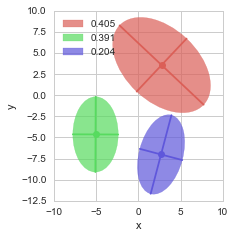

In [51]:
fig_gmm, ax = plt.subplots(figsize=(3.5,3.5))
plot_gmm_ellipses(gmm,ax=ax)

## 5.2 Goodness-of-fit statistics

In [52]:
gof_df(gmm_pdf_result, kde_result)

R_square    K_S Chi_square           MSE RMSE / Max RMSE / Mean
0    0.972  0.028      2.688  2.835794e-08      0.031       0.237

In [53]:
X = Y = PLOT_AXIS_RANGE
pdf_Z = generate_Z_from_X_Y(X,Y, mixed_model_pdf)# passing a function as an argument

def residule_between_kde_and_gmm(points):
    kde_vals = exp(kde.score_samples(points))
    gmm_vals = mixed_model_pdf(points)
    return kde_vals - gmm_vals 

residual_Z = generate_Z_from_X_Y(X,Y, residule_between_kde_and_gmm)

plot_3d_prob_density(X,Y,pdf_Z)
plot_3d_prob_density(X,Y,residual_Z)
align_figures()

fig = plt.figure(figsize=(4,3))
plot_2d_prob_density(X,Y,kde_Z,xlabel='x',ylabel='y')
fig_gmm = plt.figure(figsize=(4,3))
plot_2d_prob_density(X,Y,pdf_Z,xlabel='x',ylabel='y')
fig = plt.figure(figsize=(4,3))
plot_2d_prob_density(X,Y,residual_Z,xlabel='x',ylabel='y')
align_figures()

<img style="margin:0" align="left" src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAATkAAAE5CAYAAADr4VfxAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAALEgAACxIB0t1+/AAAIABJREFUeJzsvXuUM2d9JvhUle5Sq+/dX99vHzaDDcQ2ZDdxIImDl8QL
ybJOMGTgBMdMSE4CyUBm7GA88QabS0hMZmPiSTCELB6CPezsMBxyziZgbzwhBDCOQ7Axwd39dbda
Uuvaukulqnr3D/X7dqlUVaqSSt1Su55zfNxfq+qtt6WqR7/r8+MIIQQuXLhwcUHBn/cGXLhw4WKQ
cEnOhQsXFxouyblw4eJCwyU5Fy5cXGi4JOfChYsLDZfkXLhwcaHhkpwLFy4uNFySc+HCxYWGS3Iu
XLi40HBJzoULFxcaLsm5cOHiQsMlORcuXFxouCTnwoWLCw2X5Fy4cHGh4ZKcCxcuLjRcknPhwsWF
hktyLly4uNBwSc6FCxcXGi7JuXDh4kLDJTkXLlxcaLgk58KFiwsNl+RcuHBxoeGSnAsXLi40XJJz
4cLFhYZLci5cuLjQ8Jz3BlycPwghEEURkiRBEAR4vV7wPA+O4857ay5c9A2OEELOexMuzg+NRgOF
QgFjY2NoNpsAgHg8jsnJSYyNjYHneZf0XIw0XEvuRQxZllGr1ZBOpxEOhyFJErxeLwghIIRAlmVI
kgRRFMFxHARBcEnPxcjBJbkXIQghkCQJsiyD4zjIsozt7W3IsgyPxwNFUVCtVuH3++HxnN4ilPQa
jQZ4nocgCBAEAR6PxyU9F0ML1119kUFRFDSbTdCPPZFIIJfLYXV1FT6fD6IoIplMguM4NJtNeDwe
hEIhBINBhEIhCILQth5dh+M4RnYej6fjOBcuzguuJfciAXU/ZVkGAEiShFgsBkVR4PV6MTY2BlEU
EQgE4PV6MT4+jnA4jEajgWq1ikKhgKOjI0Z6lPjUZCZJEgghaDQaSKVSmJ+fh8/nc0nPxbnCJbkX
ARRFgSRJUBQFHMehVCrh8PAQU1NTiEaj2N/fbzue4zgQQsBxHAKBAAKBAKampkAIQb1eR61Ww/Hx
MZLJJLxeLyM8NelVKhWIoshIj7q3rqXn4qzhktwFB42j0WRCMplEsVjEysoKs9SsRiw4jmNkpia9
arWK4+NjJBIJ+Hw+hEIhEEIYqQKncUCX9FycNVySu6BQFAWyLENRFACAKIo4ODiAz+fD1tYWSyj0
kyxQkx69JrX0FEXBwcEB/H4/i+cFg0HwfKv+3CU9F2cFl+QuIBRFQSaTQaFQwOrqKvL5PJLJJObm
5jA1NdVBbFpLjrqrdsHzPIvXFYtFLCwssExtLpdDvV6H3+9vc2/NSK9cLiMajcLv97uk56JnuCR3
wUDdU6BFHLFYDLVaDRsbGwgEAh3HD7Lsg+d5BAIBhEIhAC3yrdVqqNVqyGazaDQaCAQCzNILBAJt
pJdKpeDxeCBJkmvpuegZLsldEGhr35rNJsrlMiYmJrC1tcXIw+hcYLCEB7RILxwOIxwOAzglvWq1
ikwmw0iPWno0+UEtSyP31ufzuTV6LgzhktwFgLb2LZPJIJVKwefzYWlpyfRcPXLo1V21Cy3p0Q4M
2oUhSRKSySTC4TCz9LolMmjvrUt6LihckhtxUOsNaJHE4eEhJEnCpUuXUCwWLa0xLPXggiAgEokg
EokAAHZ2dhCNRiGKIlKpFJrNZpulp0d6zWYT9XqdkR7HcfB6va57+yKGS3IjCq17Wi6XEYvFMDEx
gdXVVVQqFUvkZWTxOEF8/a7BcRxCoRAmJiYAnFp61WoVR0dHkCSJkV4oFILf7+8gvUQiwdZwLb0X
J1ySG0Goa98A4OjoCPl8HktLSxgbG2PH9UoyThDAIEhEa+lJksRIL5lMQpKktnIVv9/P9mJk6bmk
d/HhktwIgRCCbDYLr9eLQCCAZrOJWCwGjuOwtbUFr9fLjrX60J5V/G0Q8Hg8GBsbY8SuJr3j42PI
sswSLn6/vy1BoSY9GtOjxOeS3sWCS3IjAtqalc/nWZzq8PAQMzMzmJmZ6Xgo+yWvUSQ+PdKLx+Ps
/7Ist4kNqElPURSWwFGTnsfjgcfjcUlvhOGS3AhAlmUmaAkA+XweoihibW2N1aD1CnWfqvp3FwGU
oCjxNZvNNktPURRGeKFQqM2CU5Nes9lEqVTC/Py8S3ojCJfkhhja5EK9Xke5XIbf78fly5dNM4aj
7IYOCl6vF16vF9FoFADQbDZRrVZRq9WQy+VACGmz9CjpSZKEarXK3FuO41xLb4TgktyQQq0cAgC5
XA5HR0cIBAIYHx/vWhJhleTUMSq75446qKTU+Pg4CCFtll4ulwMABINBJiSqtnjVlp5LesMNl+SG
EOraN0VREI/HUa/XsbGxwR6+FwOcKmOxQjgcx8Hn88Hn87WRXrVaRalUQqPRwO7urq6lB7ikN8xw
SW6IoHVPq9UqDg4OMDY2xlqz7FhodiSUBmG5ObHmeZGDmvS8Xi9yuRzm5+dRrVZRqVSQyWTA83xb
yYoR6QGt8hdazKyu53MxeLgkNyTQ1r6l02lkMhksLi5ifHy8pzX7qZNzopD3ooAQwnpkfT4fJiYm
2BjHarWKcrmMVCoFQRDaEhlqC05RFKRSKYTDYYyNjbUNBaKdGS4GA5fkzhmEEFQqFSQSCayurkKW
ZSZLvrW1BZ/P13a83VibFVzkGJxVd9UuOI6D3++H3+/H5ORkG+mVSiVGemqpeLXggJ6lR4cCuaTn
LFySO0fQ5AKdgEVlyScnJzE3N9dX8/xFJq6zhhWi1CO9RqOBWq2GYrGIo6MjppYMnCY0tO6tKIoA
0DEUyCW93uGS3DlB7Z5SaaTDw0MsLy+ztiU92CEvOySXyWRQLBYRCATYaEIXLfTyZaGej0FJb39/
Hx6Pp2MokHoSGiUzOnRIO/PWJT37cO/kM4ae7lssFgMhBJcvX7ZELk66q7RMpVQqYW5ujpVQlMtl
1Gq1NnfLTJNuWOGUu9rvGjTjGo1G2QwMKhVfKBSQTCbh8/naEhlGpJdIJLCwsNA2Cc0lPWO4JHeG
0E7NKhQKiMfjmJqaYjNOu8HJnlSaveU4Dqurq2xmA3WrIpGIrnS5VsX3omMQcT07Q4HUk9A4jkOt
VmNdMK6l1x0uyZ0R1LVvhBDE43FUKhWsr6+zEgUrcCLWRhv90+k0lpaWEI/Hddu66MM1PT3dpuKb
TqchimJbJlGvLMKNCbbDjCzNhgLl83kkEgk2FIgWJtPzANe9NYNLcgOGXmvWwcEBgsEgtra2IAgC
ZFl2vKbN6DhJkpiwJs3exuPxrtaKkYqvnswRdceGAWdZUOzkOuqhQPRLhlp6hBBcuXJFdyiQmvQk
SXJJDy7JDRTaxvpsNotUKoVLly5hcnKS/X4Qhbt6x1H3NBqNYmVlhbmbvdzwetpu1WoV1WoV+Xwe
kiQhm81ibGyMdQfYhVNEOSwPdD9kqSa9XC6Hzc1NNBoNVKvVrkOBAH3SazQaiEQiF74jwyW5AYAQ
AlmW8eyzz+Ly5csAgHg8DlEUsbm5ycQcKey6oHYffq17ShvUtcfQG70Xl9jj8SAajSIajYIQgr29
Pfj9fjakhj6k9CEcpeztoGrtegH9XNSkBxgPBTIjvStXrmBtbY0VJNPiZLVFeBEwOnfaiEDbWF+p
VJBMJhGNRrG8vNx1apaVeiwroMfpuae9rmkVNJMYiURYIkNbKEvLJ9SZRLO/o1cMi9sMOEOW6oJi
NcwmodEYqloqPhAIgBDC3nc9S48WJ4866bkk5yC0rVm0ud7IeqKgN61VkrPz4G5vb2NsbKzNPdWD
dk0nyUGvUFabSRxk5tYpYukXTpJcN5hNQkulUhBFEYQQ5PP5jklo9HhJkjqk4keR9FyScwDUPZUk
iemP0dq31dV

<img style="margin:0" align="left" src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAQsAAADPCAYAAADiW/REAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAALEgAACxIB0t1+/AAAIABJREFUeJztnW1QVOcZ9//LAgFhFV+QEAVf0ESx+IJp7EyIfUpibZ1J
J45VJJbMkzBx+iF20qjxJVFMxJe01XxQayd2Mk/EWDH2g800k9aqLWPMpEELQVc0YEBUCqhod1FE
ln0+rPfh7OG83Ofs2T1n2es3szOw59zn3Lyc/17XdV/3dTn8fr8fBEEQGsRZPQGCIKIDEguCILgg
sSAIggsSC4IguCCxIAiCCxILgiC4iLd6AkY4c+aM1VMgCIHZs2dzn1tTcxw+X5ri8cTEROTl5Zkx
LdOJSrEAgMp3Tlo9hSA8Hg9cLpfV09AFzTl0isp+pOt8ny8NWdlbFY+3XFkf6pTCBrkhBEFwQWJB
EAQXJBYEQXBBYkEQBBckFgRBcEFiQRAEFyQWBEFwQWJBEAQXlohFbW0tSkpKAAButxvPPPMMSkpK
UFJSgs8++8yKKREEoUHEMzj37duHv/zlL0hOTgYAnD9/Hi+//DJeeeWVSE+FIAgdRNyyyM7Oxq5d
u4Tvz507h3/+859YtmwZ1q9fD6/XG+kpEURU0NfXh40bN6KoqAglJSVobm4OOn7ixAksWrQIRUVF
OHz4sOoYIxZ9xC2L+fPn4+rVq8L306dPx+LFi/G9730Pe/fuxZ49e7BmzRrN63g8nnBO0xB2nJMW
NOfo4R//+Ad6enpQWVmJmpoabN++HXv37gUAPHjwANu2bcORI0eQnJyM4uJiFBYW4uzZs7JjjFj0
lm8kmzdvHoYOHSp8vXnzZq5xdtpMBNhvgxMPNGdr6Oy5ZGjcmTNn8MwzzwAAZs6ciXPnzgnHGhsb
kZ2djWHDhgEI7IT9+uuvUVNTIzvm3Llz+O6773D8+HGMGzcO69evR2pqqur9LV8NKS0txTfffAMA
+PLLLzFt2jSLZ0QQ4aUFBYovNbxeb9AD7XQ60dvbKxwTi2hKSgq8Xq/imOnTp+PNN9/Exx9/jKys
LOzZs0dz3pZbFps2bcLmzZuRkJCAUaNGcVsWBBFrpKamoqurS/i+r68P8fHxsse6urrgcrkUxxix
6C2xLMaOHSsEYKZNm4ZDhw6hoqIC77//vqYpRBCxSn5+PqqqqgAANTU1ePzxx4VjOTk5aG5uxu3b
t9HT04Pq6mrMmjVLcYwRi95yy4IgCD7mzZuHL774AkuXLoXf78fWrVvx6aef4u7duygqKsLatWtR
WloKv9+PRYsWISMjQ3YMYMyiJ7EgiCghLi4O7777btB7OTk5wteFhYUoLCzUHAP0W/S67q/rbIIg
YhYSC4IguCCxIAiCCxILgiC4oABnjNLY1gWfz4/2u12yx3MyUiI8I8LukFjEGI1t/eKQmTMKLtfA
vJbGupag80g4CIDEIiYIevDzsoSvPR75Hb7ic0g4CAaJxSBGSST0QMJBMEgsBiHsgTYqEEqQcMQ2
JBaDiHCJhBxKwkGioc3Vu82Kx4ZHcB56IbEYBERSJOSQCgdAoqFGp/9pq6dgCMqziGIa27osFwop
bB5iF4UYHJBlEaXYTSTECIJR10IWxiDC8lYAzc3NKC4uxosvvoiysjL09fVZMaWowY7WhBI5eVlk
YQwiIi4W+/btw9tvv4379+8DALZt24bXX38dBw8ehN/vx/HjxyM9pahBLBJ2FwoGCcbgwfJWAOfP
n8dTTz0FAJg7dy5Onz4d6SlFBdFiTchBgjE4sLwVgN/vh8PhABAoMspb5t2O5eDDNadWjx9AID1b
KevSKGZfT4nR44fjUuMNAECmyxHStez4t48FLA9wxsX1GzddXV1CEVEt7FYOPhwl6tmn8eMzw2NN
eDxe2b0h4cI1MxWNdS1ov2t8aXUwtAKIViwXi9zcXHz11VeYM2cOqqqq8IMf/MDqKdmCSLgdTd09
cD64o3g8d8Qw0++Zk5clJHHRSkl0YblYrFmzBhs2bMDOnTsxceJEzJ8/3+opWU44hcJ9K1gccqZk
ys+hvnXAuYxQRYSWVqMTS8RC3ApgwoQJOHDggBXTsB2REgkmEGq+P4+ImCEaJBjRg+WWBREgXEIh
JxKhIL6Gu75V+NqocJBg8NPX14dNmzbh4sWLSExMRHl5OcaNGyccP3HiBPbs2YP4+HgsWrQIS5Ys
0Rzz6aef4sCBA6isrNS8P4mFDQiHUJgtEnKw6zJrIxRLg2IY2pjZGBkIdFI/cuQI/H4/1/1pb4jF
hFMocqZkhk0oxLB7KMU4NMfTfhIueBsjJyYmCo2RlcZ0dnZi586dWL9+Pff9ybKwAWYJhVgkIo0g
GA9dE71WRiytknzrua54bK7KOKUmx/Hx8boaI/f09OCtt97CunXr8Mgjj3DPm8TCQhrbukwRiki4
HLzkTMk07JYwwRjsOJFnaJxZjZHr6+vR3NyMTZs24f79+2hoaMCWLVvw1ltvqd6fxMIizDC5QxWJ
hp57iL/do3tcXtpI1eOhCAZA8Qsl8vPzcfLkSSxYsEC1MfKQIUNQXV2N0tJSOByOAWOmT5+Ov/71
rwCAq1ev4o033tAUCoDEwhJCjVOEIhJ1t28KX495NNVQNmTd5XYA6qJhVDBixbowgpmNkY3g8POG
Qm3EmTNnUPnOSaunEQRvGnKorofRuIRYJCZNHA0gtNTphoeCAaiLRqOBGIZatS27pXsXlf0Is2fP
5j7/zJkz+H/4WvH4/8X3dV0vktBqSIRgdSisFIpJE0cLQhEq4muJhUiKkZWSaNxZGwuQWEQAM5ZH
3bfu6F4Krbt9E3W3b5oqElL0CIYeaFu7/aCYRZgxUyh4kXM5uMZ5OmTfz3Olq46bNHE0Gi63o+72
TUWXJGdKJtz1rboDnhTstA8kFmEk0kKhVyQafF7Ee7qD3nsiK1gYLrZ0DBAROfHgEQwAugKeFOy0
FyQWYcIqodASCfGDnz1SezVETTykoqElGEZWSGjviH2gmEUYMEsoeNATl2AP+RNZ6QNEgBfxWDm3
RSuGYTQ1nOIX1kNiESYiseqhx5oQC4UZRFIwaHXEHthGLBYuXIiSkhKUlJRg3bp1Vk/HMKF+AoZD
KIDQrAklIi0YZF1Yiy1iFvfv34ff70dFRYXVUwkJszIz1YSCVyQAmG5NyPFEVroQx1CKYSjBYhh6
aPX4YaOcrJjCFpZFfX097t27h1deeQUvvfQSampqrJ6SYWJJKBhqFgagnYNB7kh0YAvLIikpCaWl
pVi8eDGamprw6quv4vPPPxd21Mlht3LwrR4/MnOGGyqt39Qd2MyVmT1M9efq9fkw5tFUzZ+9wReY
Q/ZI7XPFx7+Nkz93cp/2R/ljaUm4ctOL/9xuxSRn/5bojPRkXPuvF/+52Y5JicmyY0ePSUXdlVsY
n5SoeR8AuHT9fyG3E7ASd2eb8kEbt1G3hVhMmDAB48aNg8PhwIQJE5CWloaOjg5kZip/ytppf0DA
/fDpLqvPPlEfnzZW89y62zcxZbJGHOPhJ/u08XzLreJ9FrXdbXDCiamZwVbLhdZ2XHbeBQDMSMpQ
vd40lwsXWzoG/G2muFxouNyOJl+PYg5Gu9OLlgc+7SXVHKC9qRMuV/QupWY4cqyegiFs4YYcOXIE
27dvBwC0tbXB6/UiPT385rMZsDhFZs4oXeP07PNgS6Oq54TgdtR2Bz7ppELB3mOv2u424VwlnshK
j+iSKhE5bCEWP//5z+HxeFBcXIxf//rX2Lp1q6oLYheMBjT1CoXmOWESCim8ohGqYGhBKyPWYIsn
MjExETt27LB6GroIdeVDj1CoWRWRDGQypmaOxoXWdtR2t6m6JkZXSIzsISHCjy0si2gjFKHgSeHm
ycpkiVah5k+

In [54]:
def f(V,theta):
    return (mixed_model_pdf([[V*cos(theta),V*sin(theta)]]))*V

D:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: RuntimeWarning: divide by zero encountered in log
D:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:11: RuntimeWarning: divide by zero encountered in log
D:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:16: RuntimeWarning: divide by zero encountered in log


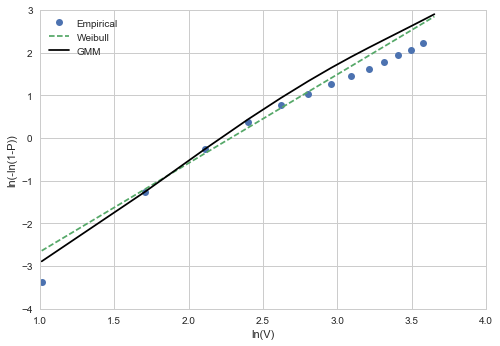

In [55]:
x = linspace(0, max_speed, 15)

# 1. Plot v-p points, empirical distribution
ecdf = sm.distributions.ECDF(df.speed)
y = ecdf(x)
plot(log(x), log(-log(1-y)),'o', label = 'Empirical')

# 2. Weibull distribution
weibull_params = sp.stats.weibull_min.fit(df.speed, loc=0)
y_cdf_weibull = sp.stats.weibull_min.cdf(x, *weibull_params)
plot(log(x), log(-log(1-y_cdf_weibull)),'--', label = 'Weibull')

# 3. GMM distribution
y_ = [integrate.nquad(f, [[0, x_val],[0, 2*pi]]) for x_val in x]
y = array(list(zip(*y_))[0])
plot(log(x), log(-log(1-y)),'-', color='black', label = 'GMM')

plt_configure(xlabel='ln(V)',ylabel='ln(-ln(1-P))',legend={'loc':'best'})

Direction Distribution Comparison


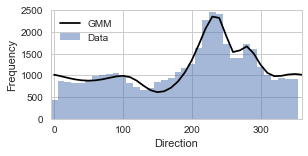

In [56]:
# Calculate Angle Distribution
x = linspace(0,2*pi, num=36+1)
y_ =[integrate.nquad(f, [[0, inf],[x_-pi/36, x_+pi/36]]) for x_ in x]
y = array(list(zip(*y_))[0])*len(df['dir']) 

df['dir'].hist(bins=DIR_BIN, alpha=0.5, label='Data')
plot(x/pi*180, y,'-', color='black', label='GMM')
title='Direction Distribution Comparison'
plt_configure(xlabel='Direction',ylabel='Frequency', 
              legend={'loc': 'best'} ,tight='xtight',figsize = (4.5,2))
dir_fig = plt.gcf()
print(title)

Speed Distribution Comparison


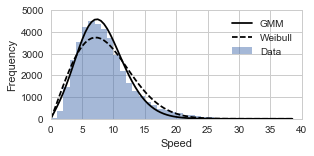

In [57]:
# Calculate Speed Distribution
# 1. GMM Model
x = arange(0, max_speed, 0.5)
y_ =[integrate.nquad(f, [[x_-0.01, x_+0.01],[0, 2*pi]]) for x_ in x]
y = array(list(zip(*y_))[0])*len(df.speed)/0.02
plot(x, y,'-', color='black', label='GMM')

# 2. Observation
df['speed'].hist(bins=arange(0, df.speed.max()), alpha=0.5, label='Data')

# 3. Weibull
y_weibul = sp.stats.weibull_min.pdf(x, *weibull_params)* len(df.speed)
plot(x, y_weibul, '--', color='black', label='Weibull')   

title='Speed Distribution Comparison'
plt_configure(xlabel='Speed',ylabel='Frequency',legend=True, figsize=(4.5, 2))
plt.gca().set_ylim(bottom = 0)
plt.locator_params(axis='y', nbins=5)
print(title)

In [58]:
# %%time
incre = max(SECTOR_LENGTH, 10)
density_collection=Parallel(n_jobs=-1)(delayed(direction_compare)(gmm, df, angle, incre) 
                                        for angle in arange(0, 360, incre))  
# This R square is computed as in paper 
# Comparison of bivariate distribution constructionapproaches for analysing wind speed anddirection data
# http://onlinelibrary.wiley.com/doi/10.1002/we.400/full
print(true_R_square(density_collection))

PicklingError: Can't pickle <function direction_compare at 0x000000000BD502F0>: it's not the same object as helpers.parallel_helper.direction_compare

## 5.3 Sectoral Comaprison

In [ ]:
# Calculate Speed Distribution
def model_data_comparison(df, original_incre = 10, incre = 10):
    start, end = -original_incre/2 + incre/2, 360
    max_diff_array = []
    curve_collection = []
    max_speed = df.speed.max()
    
    # Find a max count for plotting histogram
    max_count = max_count_for_angles(df, start, end, incre)
    plot_range = [0, max_speed, 0, max_count*1.05]
    
    for angle in arange(start, end, incre):
        angle_radian, incre_radian = radians(angle), radians(incre)  
        start_angle, end_angle = angle-incre/2, angle+incre/2
        
        # Select data from observation
        sub_df, sub_max_speed = select_df_by_angle(df, start_angle, end_angle)
        data_size = len(sub_df.speed)
        direction_prob = integrate.nquad(f, [[0, inf],
                                             [angle_radian-incre_radian/2, angle_radian+incre_radian/2]])
        weibull_params = sp.stats.weibull_min.fit(sub_df.speed, loc=0)
        
        fig = plt.figure(figsize=(13,1.3))
        x = linspace(0, sub_max_speed, 20)
        # 1. Frequency Comparison
        ax1 = fig.add_subplot(1,3,1)        
        # 1.1. Data Histogram
        sub_df['speed'].hist(bins=arange(0, sub_max_speed), alpha=0.5, label='Data')             
        # 1.2. Model Distribution
        y_gmm_ =[integrate.nquad(f, [[x_-0.01, x_+0.01], 
                                     [angle_radian-incre_radian/2, angle_radian+incre_radian/2]]) 
                                 for x_ in x]
        y_gmm = array(list(zip(*y_gmm_))[0])/direction_prob[0]/0.02
        plot(x, y_gmm*data_size,'-', color='black', label='GMM')
        # 1.3 Weibull Distribution
        y_weibull = sp.stats.weibull_min.pdf(x, *weibull_params)
        plot(x, y_weibull*data_size, '--', color='black',label='Weibull')   
        plt_configure(xlabel = "V", ylabel='Frequency', legend=True)
        plt.axis(plot_range)
        
        # 2. CDF Comaprison
        ax2 = fig.add_subplot(1,3,2)
        # 2.1. Empirical distribution
        ecdf = sm.distributions.ECDF(sub_df.speed)
        y_ecdf = ecdf(x)
        # 2.2. Model
        y_ =[integrate.nquad(f, [[0, x_val],[angle_radian-incre_radian/2, angle_radian+incre_radian/2]]) 
             for x_val in x]
        y_cdf_gmm = array(list(zip(*y_))[0])/direction_prob[0]
        # 2.3 Weibull
        y_cdf_weibull = sp.stats.weibull_min.cdf(x, *weibull_params)      
        plot(x, y_ecdf,'o', alpha=0.8, label='Data')
        plot(x, y_cdf_gmm,'-', color='black',label='GMM')
        plot(x, y_cdf_weibull,'--', color='black',label='Weibull')
        plt.gca().set_xlim(right = max_speed)
        plt_configure(xlabel = "V", ylabel='P', legend=True)
        
        # 3. Weibull Comparison
        ax3 = fig.add_subplot(1,3,3)
        plot(log(x), log(-log(1-y_ecdf)),'o', alpha=0.8, label='Data')
        plot(log(x), log(-log(1-y_cdf_gmm)),'-', color='black', label='GMM')
        plot(log(x), log(-log(1-y_cdf_weibull)),'--',color='black',label='Weibull')
        plt_configure(xlabel="ln(V)", ylabel="ln(-ln(1-P)",legend={'loc':'best'})
        plt.gca().set_xlim(right = log(max_speed+1))
        
        print('%s (%s - %s) degree' % (angle, start_angle, end_angle)     )

        bins = arange(0, sub_df.speed.max()+1)
        density, _ = np.histogram(sub_df['speed'],bins=bins, normed=True)
        density_expected_ =[integrate.nquad(f, [[x_, x_+1],[angle_radian-incre_radian/2, angle_radian+incre_radian/2]]) 
                    for x_ in bins[:-1]]
        density_expected_gmm = array(list(zip(*density_expected_ ))[0])/direction_prob[0]
        R_square_gmm = sector_r_square(density, density_expected_gmm)
        
        density_expected_weibull = sp.stats.weibull_min.cdf(bins[1:], *weibull_params) - sp.stats.weibull_min.cdf(bins[:-1], *weibull_params) 
        R_square_weibull = sector_r_square(density, density_expected_weibull)

        diff, diff_weibull= np.abs(y_ecdf - y_cdf_gmm), np.abs(y_ecdf - y_cdf_weibull)
        max_diff_array.append([len(sub_df), angle, diff.max(), x[diff.argmax()], 
                               diff_weibull.max(), x[diff_weibull.argmax()], R_square_gmm, R_square_weibull])
        curves = {'angle': angle, 'data_size': data_size, 'weight': direction_prob[0], 
                  'x': x, 'gmm_pdf': y_gmm, 'gmm_cdf': y_cdf_gmm,
                  'weibull_pdf': y_weibull, 'weibull_cdf': y_cdf_weibull, 'ecdf': y_ecdf}
        curve_collection.append(curves)
        
        plt.show()
        print('data size:', len(sub_df), 'weight', len(sub_df)/len(df))
        print('GMM', 'Weibull')
        print('R square', R_square_gmm,  R_square_weibull)
        print('max diff:', diff.max(), diff_weibull.max(), 'speed value:', x[diff.argmax()], 'y gmm', y_cdf_gmm[diff.argmax()])
        print(' ')
    return max_diff_array, curve_collection

In [ ]:
%%time
if len(effective_column) == 16:
    rebinned_angle = 22.5
else: 
    rebinned_angle = 20
max_diff_array, curve_collection = model_data_comparison(df, SECTOR_LENGTH, rebinned_angle)

In [ ]:
diff_df = pd.DataFrame(max_diff_array,columns=['datasize','direction', 'gmm', 'speed_gmm',
                                               'weibull', 'speed_weibull', 'r_square_gmm', 'r_square_weibull'])  

gmm_mean, weibull_mean = plot_sectoral_comparison(diff_df.r_square_gmm, diff_df.r_square_weibull, diff_df.direction, diff_df.datasize)
plt_configure(ylabel="$\ R^2$")
ylim = min(plt.gca().get_ylim()[0],0.85)
plt.gca().set_ylim(top=1, bottom=ylim)
print(gmm_mean, weibull_mean)

In [ ]:
gmm_mean, weibull_mean = plot_sectoral_comparison(diff_df.gmm, diff_df.weibull, diff_df.direction, diff_df.datasize)
plt_configure(ylabel="K-S")
ylim = max(plt.gca().get_ylim()[1],0.15)
plt.gca().set_ylim(top=ylim, bottom=0)
print(gmm_mean, weibull_mean)

In [ ]:
# Compare direction weight with previous figure
display(dir_fig)

### 5.3.1 Data Variability, by Bootstrap (Resampling)

In [ ]:
max_diff_element = max(max_diff_array, key=lambda x: x[2])
angle =  max_diff_angle = max_diff_element[1]
incre = rebinned_angle

In [ ]:
FRACTION = 1

# Select data from observation
start_angle, end_angle = angle-incre/2, angle+incre/2
angle_radian, incre_radian = radians(angle), radians(incre)  
sub_df, sub_max_speed = select_df_by_angle(df, start_angle, end_angle)
weibull_params = sp.stats.weibull_min.fit(sub_df.speed, loc=0)

In [ ]:
fig = plt.figure(figsize=(13,1.5))
ax1 = fig.add_subplot(1,3,1)   
ax2 = fig.add_subplot(1,3,2)   
ax3 = fig.add_subplot(1,3,3)   

x = arange(0, sub_max_speed, 0.5)

# 1. Data
bins=arange(0, sub_max_speed)
sub_df['speed'].hist(ax=ax1, bins=bins, alpha=0.5, label='Data', normed=True)  

# 2. GMM
y_gmm_ =[integrate.nquad(f, [[x_-0.01, x_+0.01], [angle_radian-incre_radian/2, angle_radian+incre_radian/2]]) 
          for x_ in x]
direction_prob = integrate.nquad(f, [[0, inf], [angle_radian-incre_radian/2, angle_radian+incre_radian/2]])
y_gmm = array(list(zip(*y_gmm_))[0])/direction_prob[0]/0.02  
y_gmm_cdf_ =[integrate.nquad(f, [[0, x_val],[angle_radian-incre_radian/2, angle_radian+incre_radian/2]]) for x_val in x]
y_gmm_cdf = array(list(zip(*y_gmm_cdf_))[0])/direction_prob[0]
ax1.plot(x, y_gmm,'-', color='black', label='GMM')
ax2.plot(x, y_gmm_cdf,'-', color = 'black', label='GMM')
ax3.plot(log(x), log(-log(1-y_gmm_cdf)),'-', color = 'black',label='GMM')

# 3. Weilbull 
y_weibull = sp.stats.weibull_min.pdf(x, *weibull_params)
y_weibull_cdf = sp.stats.weibull_min.cdf(x, *weibull_params)
ax1.plot(x, y_weibull,'--',color='black',label='Weibull')
ax2.plot(x, y_weibull_cdf,'--',label='Weibull')
ax3.plot(log(x), log(-log(1-y_weibull_cdf)),'--',label='Weibull')

# 4. Data Resampled
count_collection = []
for i in range(1,100):
    sub_df_resampled = sub_df.sample(frac=FRACTION, replace=True)    
    resampled_count, _ = np.histogram(sub_df_resampled['speed'], bins=bins, normed=True) 
    count_collection.append(resampled_count)
    
    ecdf = sm.distributions.ECDF(sub_df_resampled.speed)
    y_ecdf = ecdf(x) 
    ax2.plot(x, y_ecdf,':', label='Data Resampled')
    ax3.plot(log(x), log(-log(1-y_ecdf)),':', label='Data Resampled')
    if i == 1: 
        plt_configure(ax=ax2, xlabel='V',ylabel='P',legend={'loc':'best'})
        plt_configure(ax=ax3, xlabel='V',ylabel='ln(-ln(1-P)',legend={'loc':'best'})

print('%s (%s - %s) Degree Speed Distribution' % (angle, start_angle, end_angle))
count_collection = np.array(count_collection)
mx, mn = np.max(count_collection,0), np.min(count_collection,0)
ax1.plot(bins[1:]-0.5, mx, ':', color='blue')
ax1.plot(bins[1:]-0.5, mn, ':', color='blue', label='Resample limit')
ax1.set_ylim(bottom = 0)
plt_configure(ax=ax1, xlabel='V',ylabel='Frequency',legend={'loc':'best'})
ax1.locator_params(axis='y', nbins=5)
ax2.locator_params(axis='y', nbins=5)
ax3.locator_params(axis='y', nbins=5)

diff = abs(y_ecdf - y_gmm_cdf)
print(diff.max(), x[diff.argmax()], y_gmm_cdf[diff.argmax()])

### 5.3.2 Time Variability

In [ ]:
fig_time_variability_3d = plt.figure()
ax1 = fig_time_variability_3d.gca(projection='3d')

fig_time_variability_cdf,ax2 = plt.subplots(figsize=(3,1.8))
fig_time_variability_weibull, ax3 = plt.subplots(figsize=(3,1.8))
 
x = arange(0, sub_max_speed, 0.5)

# 1. GMM
direction_prob = integrate.nquad(f, [[0, inf], [angle_radian-incre_radian/2, angle_radian+incre_radian/2]])
y_gmm_ =[integrate.nquad(f, [[x_-0.01, x_+0.01], [angle_radian-incre_radian/2, angle_radian+incre_radian/2]]) 
          for x_ in x]
y_gmm = array(list(zip(*y_gmm_))[0])/direction_prob[0]/0.02
y_gmm_cdf_ =[integrate.nquad(f, [[0, x_val],
                         [angle_radian-incre_radian/2, angle_radian+incre_radian/2]]) for x_val in x]
y_gmm_cdf = array(list(zip(*y_gmm_cdf_))[0])/direction_prob[0]

ax2.plot(x, y_gmm_cdf,'-', color='black', label = 'GMM')
ax3.plot(log(x), log(-log(1-y_gmm_cdf)),'-', color='black',label='GMM')

# 2. Weibull
y_weibull = weibull_min.pdf(x, *weibull_params)
y_weibull_cdf = weibull_min.cdf(x, *weibull_params)
ax2.plot(x, y_weibull_cdf,'--', label='Weibull')
ax3.plot(log(x), log(-log(1-y_weibull_cdf)), '--', label='Weibull')

# 3. Data
prop_cycle=iter(mpl.rcParams['axes.color_cycle'])
for start_time in range(20000000, 20150000, 50000):
    end_time = start_time + 50000 
    time_label = start_time//10000
    df_other_years = df_all_years.query('(date >= @start_time) & (date < @end_time)')
    df_other_years_at_angle, sub_max_speed_other_year = select_df_by_angle(df_other_years, start_angle, end_angle)
    if len(df_other_years_at_angle) > 0 :
        
        ecdf = sm.distributions.ECDF(df_other_years_at_angle.speed)
        y_ecdf = ecdf(x)
        ax2.plot(x, y_ecdf,':', label = time_label)
        ax3.plot(log(x), log(-log(1-y_ecdf)),':', label = time_label)
        
        title = '%s - %s' %(time_label, time_label+4)
        count, division = np.histogram(df_other_years_at_angle['speed'], normed=True,
                                       bins=arange(0, sub_max_speed_other_year))
        ax1.bar(left=division[:-1], height=count, zs=time_label, zdir='x', 
                color=next(prop_cycle), alpha=0.8)
        x_3d = time_label*np.ones_like(x)
        ax1.plot(x_3d, x, y_gmm, '-', color='black', label='GMM'  if time_label == 2010 else '')
        ax1.plot(x_3d, x, y_weibull, '--', color='blue', label='Weibull' if time_label == 2010 else '')
        
print('%s (%s - %s) Degree Speed Distribution' % (angle, start_angle, end_angle))
ax1.set_ylim(bottom = 0)
ax1.set_zlabel('Frequency')
plt_configure(ax=ax1, xlabel='Time',ylabel='V', legend=True)
plt_configure(ax=ax2, xlabel='V',ylabel='P',legend={'loc':'best'})
plt_configure(ax=ax3, xlabel="ln(V)", ylabel="ln(-ln(1-P)",legend={'loc':'best'})
ax1.set_zlim(bottom = 0)
align_figures()

### 5.3.3 Adjacent Sector Variability

In [ ]:
incre = rebinned_angle
angle_group = [max_diff_angle-incre, max_diff_angle, max_diff_angle+incre]

In [ ]:
fig_adjecent_variability_3d = plt.figure()
ax1 = fig_adjecent_variability_3d.gca(projection='3d')
fig_adjecent_variability_cdf, ax2 = plt.subplots(figsize=(3,1.8))
fig_adjecent_variability_weibull, ax3 = plt.subplots(figsize=(3,1.8))

legend_3d = False
prop_cycle=iter(mpl.rcParams['axes.color_cycle'])

curve_df = pd.DataFrame(curve_collection)

for angle in angle_group:
    curves = curve_df.query('angle == @angle%360').T.to_dict()
    curves = curves[list(curves)[0]]
    data_size, x =  curves['data_size'], curves['x']
    y_gmm, y_cdf_gmm =  curves['gmm_pdf'], curves['gmm_cdf'] 
    y_weibull, y_cdf_weibull, y_cdf = curves['weibull_pdf'],  curves['weibull_cdf'], curves['ecdf']

    linestyle = '-' if angle == max_diff_angle else ':'
    alpha = 0.7 if angle == max_diff_angle else 0.3

    ax2.plot(x, y_gmm*data_size, linestyle, label=angle)        
    ax3.plot(x, y_weibull*data_size, linestyle, label=angle)

    start_angle, end_angle = angle-incre/2, angle+incre/2
    sub_df, sub_max_speed = select_df_by_angle(df, start_angle, end_angle)

    x_3d = angle*np.ones_like(x)
    ax1.plot(x_3d, x, y_gmm*data_size, color='black', label='GMM')
    ax1.plot(x_3d, x, y_weibull*data_size, color='blue', linestyle='--',label='Weibull')

    count, division = np.histogram(sub_df['speed'], bins=arange(0, sub_max_speed))
    ax1.bar(left=division[:-1], height=count, zs=angle, zdir='x', color=next(prop_cycle), alpha=0.8)

    if legend_3d == False:
        ax1.legend()
        legend_3d = True
        
plt_configure(ax=ax1, xlabel='Direction', ylabel='Speed')   
plt_configure(ax=ax2, xlabel='V',ylabel='Frequency',legend={'loc':'best'})
plt_configure(ax=ax3, xlabel='V',ylabel='Frequency',legend={'loc':'best'})
ax1.set_zlabel('Frequency')
ax1.set_zlim(bottom = 0)
ylim = max(ax1.get_ylim()[1],ax3.get_ylim()[1])
ax2.set_ylim(bottom = 0, top=ylim)
ax3.set_ylim(bottom = 0, top=ylim)

print(max_diff_angle) 
print('GMM, Weibull, Histogram')
align_figures()

# 6. Result Variability & Cross-Validation

In [ ]:
if 'bandwidth' not in globals():
    bandwidth = DEFAULT_BANDWDITH    
if 'FIT_METHOD' not in globals():
    FIT_METHOD = 'square_error'       
if 'KDE_KERNEL' not in globals():
    KDE_KERNEL = 'gaussian'
    
config = {'bandwidth': bandwidth, 
          'fitting_range': FITTING_RANGE,
          'fit_limit': fit_limit,
          'kde_kernel': KDE_KERNEL}

## 6.1 Variability of the Result

In [ ]:
%%time
results = Parallel(n_jobs=-1)(delayed(resampled_fitting)(df, FIT_METHOD, NUMBER_OF_GAUSSIAN, config) for i in range(10))                        
for result in results:
    display(pretty_print_gmm(result['gmm']))
    fig,ax = plt.subplots(figsize=(3.5,3.5))
    plot_gmm_ellipses(result['gmm'],ax=ax)
    plt.show()
    
    display(gof_df(result['gmm_pdf_result'], result['kde_result']))
    display(gof_df(result['gmm_pdf_result'], kde_result))
    print('')

## 6.2 Cross-validation, to select the number of Gaussian

In [ ]:
%%time
from sklearn.cross_validation import train_test_split, KFold

## 5-fold cross validation
gaussian_number_range = arange(1,6)
CV_result_train_all,CV_result_test_all =[],[]
number_of_fold = 4
print('Number of train/test dataset', len(df)*(number_of_fold-1)/number_of_fold, len(df)/number_of_fold) 

for number_of_gaussian in gaussian_number_range:
    print( '  ')
    print('Number of gaussian', number_of_gaussian)
    
    kf = KFold(len(df), n_folds=number_of_fold, shuffle=True) 

    CV_result = Parallel(n_jobs=-1)(delayed(fit_per_fold)(df, train_index, test_index, FIT_METHOD, number_of_gaussian, config) for train_index, test_index in kf)                        

    CV_result_train, CV_result_test = list(zip(*CV_result))
    CV_result_train, CV_result_test = list(CV_result_train), list(CV_result_test)
        
    CV_result_train_all.append(CV_result_train)
    CV_result_test_all.append(CV_result_test)
    
    print('Train')
    pretty_pd_display(CV_result_train)
    print('Test')
    pretty_pd_display(CV_result_test)

In [ ]:
train_scores_mean, train_scores_std = generate_mean_std_gof(CV_result_train_all)
print('Train gof mean, std')
display(train_scores_mean)

test_scores_mean, test_scores_std = generate_mean_std_gof(CV_result_test_all)
print('Test gof mean, std')
display(test_scores_mean)

In [ ]:
prop_cycle=mpl.rcParams['axes.color_cycle']
gaussian_number_range = train_scores_mean.index
for column, column_name in zip(['R_square','K_S','Chi_square'],["$\ R^2$", "K-S", "$\widetilde{\chi^2} $"]):
    plot(gaussian_number_range, train_scores_mean[column],
             '--', label = 'train', color=prop_cycle[0])
    plt.fill_between(gaussian_number_range, 
                     train_scores_mean[column] - train_scores_std[column],
                     train_scores_mean[column] + train_scores_std[column], 
                     alpha=0.2, color=prop_cycle[0])
    
    plot(gaussian_number_range, test_scores_mean[column],
             '-', label = 'test',color=prop_cycle[1])
    plt.fill_between(gaussian_number_range, 
                 test_scores_mean[column] - test_scores_std[column],
                 test_scores_mean[column] + test_scores_std[column], 
                 alpha=0.2,color=prop_cycle[1])
    plt.xticks(gaussian_number_range)
    print(column)
    plt.locator_params(axis='y', nbins=5)
    plt_configure(xlabel='Number of Gaussian Distribution', ylabel=column_name, 
                  figsize=(3,2), legend={'loc':'best'})
    if column == 'R_square':
        plt.gca().set_ylim(top=1)
    if column == 'K_S' or column == 'Chi_square':
        plt.gca().set_ylim(bottom=0)
    plt.margins(x=0, y=0)
    plt.show()

In [ ]:
for fig in [fig_hist, fig_kde, fig_em, fig_gmm]:
    display(fig)
for fig in [fig_time_variability_3d, fig_time_variability_cdf, fig_time_variability_weibull, 
            fig_adjecent_variability_3d, fig_adjecent_variability_cdf, fig_adjecent_variability_weibull,]:
    display(fig)

In [ ]:
import time
save_notebook()
time.sleep(3)
location_name = get_location_name(file_path)
current_file = 'GMM.ipynb'
output_file = './output_HTML/'+location_name+'.html' 
output_HTML(current_file, output_file)